## Índice

### 1. Introducción
- 1.1. Contexto del problema
- 1.2. Objetivo de negocio
- 1.3. Pregunta de investigación
- 1.4. Definición de la variable objetivo
- 1.5. Momento de predicción 


### 2. Carga de Datos y Preparación Inicial
- 2.1. Librerias
- 2.2. Carga de dataset
- 2.3. Inspección inicial (shape, columnas, tipos)
- 2.4. Estandarización de tipos (fechas, numéricas, categóricas)


### 3. Construcción del Target y Cohortes
- 3.1. Cálculo de `lead_time_total_horas`
- 3.2. Cálculo de `cycle_time_horas` (referencia interna)
- 3.3. Análisis de filas excluidas y sesgo potencial


### 4. Auditoría de Calidad de Datos
- 4.1. Coherencia temporal (`FechaIngreso ≤ FechaInicio ≤ FechaFin`)
- 4.2. Rango del target (detección de tiempos negativos o irreales)
- 4.3. Identificación de outliers extremos y decisiones (mantener / winsorizar / excluir)


### 5. Análisis de Valores Faltantes (Missingness)
- 5.1. Tabla general de valores faltantes por columna
- 5.2. Visualización Top-N columnas con mayores faltantes
- 5.3. Patrones de ausencia por grupos (`Ubicacion`, `TipoMaterialId`, etc.)
- 5.4. Coausencia entre variables (correlación de nulos)
- 5.5. Estrategia de manejo 


### 6. Diccionario y Agrupación de Variables
- 6.1. Agrupación y descripción de variables
- 6.2. Diccionario de datos


### 7. Estadística Descriptiva 
- 7.1. Selección de variables numéricas
- 7.2. Tabla descriptiva robusta (media, mediana, std, MAD, percentiles, CV, asimetría, curtosis)
- 7.3. Histograma + boxplot + Q-Q Plot por variable
- 7.4. Detección de min/max sospechosos y % de ceros


### 8. Análisis  con el Target
- 8.1. Correlación Spearman entre variables y `lead_time_total_horas`
- 8.2. Ranking de señal (variable ↔ target)
- 8.3. Visualizaciones de relación (scatter / tendencia)


### 9. División de Entrenamiento / Validación Temporal
- 9.1. Corte temporal por `FechaIngreso`
- 9.2. Train = histórico, Test = reciente 
- 9.3. Validación del tamaño de cada split


### 10. Conclusiones del EDA
- 10.1. Variables más relevantes
- 10.2. Principales factores que explican el tiempo de producción
- 10.3. Problemas de calidad detectados y decisiones tomadas
- 10.4. Implicaciones para el modelado predictivo


### 11. Próximos Pasos
- 11.1. Selección final de features
- 11.2. Modelos a evaluar
- 11.3. Métricas y estrategias de validación


---

## 1. Introducción

### 1.1 Contexto del problema

La fábrica de confección registra, para cada pedido y sus detalles, información operativa (materiales, diseño, máquina, operario, tiempos parciales y lecturas de proceso) junto con fechas de ingreso, inicio y fin de producción. En la operación actual, la promesa de entrega se realiza con reglas empíricas y conocimiento tácito del personal de planta, lo que genera variabilidad en los plazos comprometidos, atrasos no anticipados y sobrecostos por reprocesos o reprogramaciones.

El objetivo de este estudio es caracterizar rigurosamente los tiempos de flujo del pedido —en particular el **tiempo total desde ingreso hasta cierre, `lead_time_total_horas`**— para identificar patrones, fuentes de variabilidad y factores determinantes, y así sentar las bases de un modelo predictivo que permita **prometer fechas con mayor precisión y gestionar capacidad de forma proactiva**.

**Alcance**
- **Unidad de análisis**: pedido/detalle de pedido.
- **Periodo de estudio**: histórico disponible en las fuentes (especificar rango de fechas).
- **Variable objetivo**: `lead_time_total_horas = FechaFin − FechaIngreso` (en horas) para pedidos cerrados.
- **Momento de predicción**: en **`FechaIngreso`** al crear el pedido, de cara a promesa comercial.

**Relevancia**
- **Promesa de entrega**: mejora del SLA percibido por clientes y reducción de penalizaciones.
- **Planificación y capacidad**: priorización de órdenes y asignación de recursos (máquinas/turnos) con base en riesgo de atraso.
- **Mejora continua**: identificación de cuellos de botella (por planta, material, diseño) y cuantificación de impacto.

**Stakeholders**
- **Comercial/Customer Success**: promesa y seguimiento de fecha comprometida.
- **Planeación y Producción**: secuenciación, asignación de máquinas/operarios y control de WIP.
- **Calidad**: análisis de reprocesos y su efecto en tiempo total.
- **Dirección**: indicadores de servicio y eficiencia operativa.

**Supuestos y restricciones**
- **Integridad temporal**: se asume `FechaIngreso ≤ FechaInicio ≤ FechaFin`; las violaciones se auditarán y documentarán.
- **Mediciones homogéneas**: unidades consistentes (minutos/horas) y codificación estable de categóricas (materiales, diseños, ubicaciones). Se normalizarán si hay inconsistencias.
- **Disponibilidad de datos**: no todos los campos están completos; se aplicará una estrategia documentada para valores faltantes sin introducir fuga de información.
- **No fuga de información**: en el escenario de predicción al ingreso, no se emplearán variables que solo existen después del inicio/fin de producción.

**Decisiones metodológicas clave**
- Análisis primario sobre **pedidos cerrados** para estimar y modelar `lead_time_total_horas`.
- Cohortes y splits **temporales** para evaluación (train: histórico; test: más reciente).
- Métrica de referencia de negocio: **MAE en horas** frente a baselines (medianas globales/por grupo).
- En etapas posteriores, extensión a **tiempo restante** durante la producción (no cubierto en esta sección).

**Resultado esperado de esta etapa**
- Marco conceptual y operativo del problema claramente definido.
- Criterios de inclusión/exclusión y supuestos explícitos para todo el EDA.
- Lista de variables candidatas y riesgos de sesgo/fuga que guiarán las siguientes secciones.


### 1.2 Objetivo de negocio

**Objetivo principal**  
Mejorar la precisión de la promesa de entrega mediante la estimación del **tiempo total desde ingreso hasta cierre** del pedido (**`lead_time_total_horas`**), de forma **anticipada** (en `FechaIngreso`), para soportar decisiones comerciales y de planificación.

**Objetivos específicos**
1. **Pronóstico confiable del lead time** al momento de creación del pedido, con error absoluto medio (MAE) ≤ *X* horas (definir con stakeholders) y reducción ≥ *Y*% respecto al baseline actual (mediana histórica).
2. **Segmentación operativa**: identificar materiales, diseños y ubicaciones con mayores tiempos y variabilidad (brechas en P50/P80), para priorizar acciones de mejora.
3. **Gestión de riesgo**: proveer percentiles (P50/P80/P95) por pedido para soportar promesas conservadoras cuando sea necesario.
4. **Trazabilidad**: estandarizar el flujo de datos y las reglas de negocio (cohortes, exclusiones, manejo de nulos) para replicabilidad y auditoría.

**Indicadores (KPIs) de éxito**
- **Precisión de promesa**: MAE (horas) y MAPE (%) del pronóstico vs. `lead_time_total_horas` en conjunto de prueba **temporal**.
- **Confiabilidad**: cobertura empírica de los intervalos P50/P80 (ej., P80 cubre ~80% de los casos en test).
- **Estabilidad**: degradación ≤ *Z*% del error al comparar dos cortes temporales consecutivos (drift control).
- **Utilidad operativa**: reducción de atrasos (SLA incumplidos) y reprogramaciones (medido trimestralmente).

**Alcance (qué incluye)**
- Construcción y validación del objetivo `lead_time_total_horas` para **pedidos cerrados**.
- Análisis exploratorio y establecimiento de baselines de negocio sin ML.
- Identificación de variables predictoras **disponibles al crear el pedido** (sin fuga).
- Partición de entrenamiento/prueba por **corte temporal** (no aleatoria).

**Fuera de alcance (qué no incluye en esta fase)**
- Modelos en línea de **tiempo restante** (remaining time) durante la ejecución.
- Optimización de secuenciación en planta o simulaciones de capacidad.
- Integración en sistemas productivos (API/UX); aquí se enfoca el EDA y bases para modelado.

**Restricciones y supuestos**
- **Disponibilidad de datos**: se trabaja con el histórico vigente; pedidos sin `FechaFin` quedan fuera del cómputo del objetivo (pueden analizarse aparte).
- **Coherencia temporal**: se reportarán y tratarán inconsistencias (`FechaFin < FechaInicio`, etc.).
- **Unidades**: todas las duraciones se homologarán a **horas**.
- **Granularidad**: análisis a nivel detalle de pedido; agregación a nivel pedido cuando aplique (máx. `FechaFin`, mín. `FechaIngreso`).

**Criterios de aceptación**
- Documento EDA con: definiciones, cohortes, reglas de limpieza, análisis de nulos/outliers, descriptivas, brechas por grupos y baselines cuantificados.
- Repositorio reproducible con scripts/notebook y datasets derivados (estándar, cohortes, splits temporales).
- Métrica base (MAE) del baseline y objetivo cuantificado de mejora acordado con negocio.


### 1.3 Pregunta de investigación

**Pregunta central**  
¿Con qué precisión es posible **estimar el tiempo total de producción** de un pedido en una fábrica de confección —definido como `lead_time_total_horas = FechaFin − FechaIngreso`— **en el momento de su creación** (`FechaIngreso`), utilizando únicamente variables conocidas en ese instante (tamaño, materialidad, complejidad y contexto operativo)?

**Subpreguntas específicas**
1. **Determinantes**: ¿Qué factores (tamaño del pedido, complejidad del diseño, materialidad, ubicación/línea) explican mayor variabilidad del `lead_time_total_horas`?
2. **Capas de variabilidad**: ¿Cuánta variación se atribuye a diferencias **entre** ubicaciones/planta y cuánta a diferencias **dentro** de cada ubicación (por tipo de material o diseño)?
3. **Robustez temporal**: ¿Se mantienen estables las relaciones identificadas al evaluar en un **conjunto de prueba temporal** (histórico → reciente)?
4. **Promesa conservadora**: ¿Qué tan bien calibrados están los cuantiles operativos (P50, P80, P95) para soportar promesas de entrega conservadoras?
5. **Impacto de la calidad de datos**: ¿Cómo afectan a la precisión los **valores faltantes**, outliers y posibles inconsistencias temporales, y qué estrategias de tratamiento son más efectivas?

**Hipótesis operativas (a contrastar en el EDA)**
- **H1 (Complejidad)**: Un mayor nivel de complejidad (e.g., `NumeroApliques`, `Puntadas`, `DisenosTPTG`) se asocia con incrementos monotónicos en `lead_time_total_horas`.
- **H2 (Tamaño)**: El tamaño del pedido (`Cantidad`, `CantidadOrden`) incrementa el `lead_time_total_horas` con **rendimientos decrecientes** a partir de cierto umbral (no linealidad).
- **H3 (Materialidad)**: La materialidad (`TipoMaterialId`, insumos especiales como `Plastico`, `Chenille`) introduce diferencias sistemáticas en medianas y colas (P80/P95) del lead time.
- **H4 (Estacionalidad)**: Variables de calendario derivadas de `FechaIngreso` (mes, día de la semana, hora) explican parte de la variabilidad por efectos de demanda/capacidad.

**Operacionalización y criterios de evaluación**
- **Variable dependiente**: `lead_time_total_horas` (horas), calculada solo para **pedidos cerrados** (`FechaFin` no nula).
- **Variables independientes (disponibles al crear el pedido)**: tamaño/carga (`Cantidad`, `CantidadOrden`, `CantidadProgramada`), complejidad (`NumeroApliques`, `Puntadas`, `DisenosTPTG`), materialidad (`TipoMaterialId`, insumos/flags), producto/variante (`Talla`, `Fondo`, `ColorFondo`, `MaterialPedido`), **calendario** (de `FechaIngreso`), y **Ubicacion`.
- **Métrica principal (descriptiva para promesa)**: MAE (horas) de baselines **sin ML** (mediana global, por `Ubicacion`, por `TipoMaterialId`) como referencia para fases posteriores.
- **Métricas de calibración de cuantiles**: cobertura empírica de P50/P80/P95 en conjunto de prueba temporal.
- **Validez interna**: control de **fuga de información** (exclusión de variables posteriores a `FechaIngreso`, p.ej., `FechaInicio`, `FechaFin`, tiempos de proceso y calidad resultante).

**Supuestos y alcance de la inferencia**
- **Supuesto temporal**: `FechaIngreso ≤ FechaInicio ≤ FechaFin`; inconsistencias serán auditadas y documentadas.
- **Datos faltantes**: el tratamiento (imputación/categorización/exclusión) se definirá por tipo de variable y patrón de ausencia; se realizará análisis de **coausencia**.
- **Generalización**: las conclusiones aplican al período histórico analizado y deberán reevaluarse ante cambios estructurales (turnos, maquinaria, mezcla de productos).

**Resultado esperado de la sección**  
Un marco de investigación claro que delimite la estimación temprana del `lead_time_total_horas`, identifique los factores a evaluar en el EDA y establezca métricas y supuestos para interpretar hallazgos con rigor académico y utilidad operativa.


### 1.4 Definición de la variable objetivo  

**Definición de la variable objetivo (`lead_time_total_horas`)**  
La variable objetivo del estudio corresponde al **tiempo total transcurrido entre el ingreso del pedido y su finalización**, expresado en horas. Esta medida refleja la **duración efectiva del proceso productivo**, incluyendo esperas, secuenciaciones, actividades manuales y tiempos en máquina.

lead_time_total_horas = (FechaFin − FechaIngreso) / 3600

- `FechaIngreso`: fecha y hora en que el pedido entra al sistema productivo.  
- `FechaFin`: fecha y hora en que el pedido se termina y queda disponible como producto completo.  
- **Condición de cálculo**: solo se calcula para **pedidos cerrados** (`FechaFin` no nula). Los pedidos en ejecución pueden analizarse por separado como *pedidos en progreso*.

**Naturaleza interpretativa del objetivo**  
`lead_time_total_horas` captura no solo actividades productivas directas, sino también:
- tiempos de espera entre operaciones,
- diferencias de capacidad por turno/planta,
- variaciones por tipo de producto y material,
- ineficiencias, retrabajos o interrupciones.  
Es, por tanto, una medida **integral** del flujo del pedido a través del sistema productivo.

### 1.5 Momento de predicción

**Momento de predicción (escenario de uso)**  
La predicción se realiza **en el momento en que el pedido es creado**: `FechaIngreso`. Para **evitar fuga de información**, solo se emplearán variables **disponibles ex ante**.

**Variables permitidas en el momento de predicción**
- **Tamaño / carga**: `Cantidad`, `CantidadOrden`, `CantidadProgramada`.
- **Producto / variante**: `Talla`, `Fondo`, `ColorFondo`, `MaterialPedido`.
- **Materialidad**: `TipoMaterialId`, `codigoMaterial`.
- **Complejidad inicial**: `NumeroApliques`, `DisenosTPTG` (si se conocen desde diseño).
- **Ubicación / línea**: `Ubicacion` (y `NombreMaquina` solo si se asigna de inicio).
- **Calendario**: variables derivadas de `FechaIngreso` (`mes`, `día_semana`, `hora_ingreso`).

**Variables prohibidas (posteriores, causarían fuga)**
- **Tiempos de ejecución**: `TiempoMaquina`, `TiempoPulida`, `TiempoQuitarPlastico`, etc.
- **Resultados de calidad**: `CantidadBuena`, `CantidadMala`, `CantidadReprocesada`.
- **Fechas posteriores**: `FechaInicio`, `FechaFin`.

**Implicación metodológica**
1. El pedido ingresa (`FechaIngreso`).
2. Se conocen sus atributos iniciales.
3. Se estima `lead_time_total_horas`.
4. Se define promesa de entrega o priorización operativa.

De esto se desprende que:
- La **división de entrenamiento y prueba** debe ser **temporal** (histórico → reciente).
- La **selección de features** se fundamenta en **disponibilidad temporal**, no en mera correlación.
- La evaluación se realizará **en un conjunto de prueba temporal**, para validar la utilidad operativa.

**Resultado esperado de esta sección**
- `lead_time_total_horas` queda definida con claridad conceptual y operacional.
- Se establece el **punto de predicción** (FechaIngreso) y la **lista explícita de variables elegibles**.
- Se previene la **fuga de información**, asegurando rigor académico y relevancia práctica.


---

### 2. Carga de Datos y Preparación Inicial


#### 2.1 Librerias

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as  sns
import re
from textwrap import fill,wrap
import itertools



# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.set_palette("husl")

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Configuración reproducible
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)



#### 2.2. Carga de dataset

In [23]:
df = pd.read_csv('data/produccion.csv')
df.head()


C:\Users\Admin\AppData\Local\Temp\ipykernel_12816\1139538576.py:1: DtypeWarning: Columns (18,27,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/produccion.csv')


,Operario,PedidoId,NumeroOrden,MaterialIdOrden,TipoMaterialId,codigoMaterial,CantidadOrden,NombreMaquina,CantidadProgramada,FechaInicio,FechaFin,año,TiempoenMaquina,CantidadBuena,CantidadMala,CantidadReprocesada,MaterialId,Ubicacion,PuntoPlantilla,DisenosTPTG,InterlonId,HiloInferiorId,NumeroApliques,TiempoAlistamiento,TiempoMaquina,TiempoAplique,TiempoPulida,Velocidad,Puntadas,Plastico,MaquinaPlasticoId,TiempoQuitarPlastico,Canutillo,Chenille,Cordon,Presion,Temperatura,Unnamed: 37
0,Edward Dario Pulgarin Paniagua,5912,O11585,1625,28,U53554,241,Bordadora 12,241,2021-06-15 11:21:39.9748690,2021-06-15 17:41:58.7622990,2021,380.00,162,0,0,1625,NaN,1,NaN,NaN,91.00,0.00,NaN,NaN,NaN,NaN,NaN,1735.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Edward Dario Pulgarin Paniagua,5981,O11681,1625,28,U53554,544,Bordadora 12,544,2021-06-18 11:37:35.9040465,2021-06-23 06:47:54.1423484,2021,6910.00,471,0,0,1625,NaN,1,NaN,NaN,91.00,0.00,NaN,NaN,NaN,NaN,NaN,1735.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Edwin Alonso Jaramillo Castaño,5981,O11681,1625,28,U53554,544,Bordadora 12,544,2021-06-18 11:37:35.9040465,2021-06-23 06:47:54.1423484,2021,6910.00,5,0,0,1625,NaN,1,NaN,NaN,91.00,0.00,NaN,NaN,NaN,NaN,NaN,1735.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Francisco Nicolas Parra Acevedo,4225,O8269,1625,28,U53554,10,Bordadora 05,10,2021-03-08 10:38:09.8705291,2021-03-08 11:25:26.7423458,2021,47.00,10,0,0,1625,NaN,1,NaN,NaN,91.00,0.00,NaN,NaN,NaN,NaN,NaN,1735.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Gloria Elsy Jimenez Giraldo,831,O1339,1625,28,U53554,40,Bordadora 14,40,2020-07-07 21:00:57.3642183,2020-07-07 21:27:32.5160898,2020,27.00,13,0,0,1625,NaN,1,NaN,NaN,91.00,0.00,NaN,NaN,NaN,NaN,NaN,1735.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 2.3. Inspección inicial 

In [29]:
# Inspección inicial y vista general del dataset

print("=" * 80)
print("INFORMACIÓN GENERAL DEL DATASET".center(80))
print("=" * 80)
print(f"Filas: {df.shape[0]} | Columnas: {df.shape[1]}")
print("Listado de columnas:", sorted(df.columns.tolist()))

# Primeras filas con formato visual para detectar patrones y problemas
display(df.head().style.background_gradient(cmap='coolwarm', subset=['TiempoenMaquina']))

print("\n" + "=" * 80)
print("ESTRUCTURA DE DATOS".center(80))
print("=" * 80)
df.info()

print("\n" + "=" * 80)
print("ESTADÍSTICAS DESCRIPTIVAS".center(80))
print("=" * 80)
display(df.describe().round(2).T)

print("\nTipos de datos por columna:")
display(df.dtypes.to_frame("dtype"))

print("\nMuestra aleatoria para revisión visual:")
display(df.sample(n=min(5, len(df))))

                        INFORMACIÓN GENERAL DEL DATASET                         
Filas: 55490 | Columnas: 23
Listado de columnas: ['CantidadBuena', 'CantidadMala', 'CantidadOrden', 'CantidadProgramada', 'CantidadReprocesada', 'FechaFin', 'FechaInicio', 'HiloInferiorId', 'MaterialId', 'MaterialIdOrden', 'NombreMaquina', 'NumeroOrden', 'Operario', 'PedidoId', 'Puntadas', 'PuntoPlantilla', 'TiempoAlistamiento', 'TiempoAplique', 'TiempoMaquina', 'TiempoPulida', 'TiempoenMaquina', 'año', 'codigoMaterial']


,Operario,PedidoId,NumeroOrden,MaterialIdOrden,codigoMaterial,CantidadOrden,NombreMaquina,CantidadProgramada,FechaInicio,FechaFin,año,TiempoenMaquina,CantidadBuena,CantidadMala,CantidadReprocesada,MaterialId,PuntoPlantilla,HiloInferiorId,TiempoAlistamiento,TiempoMaquina,TiempoAplique,TiempoPulida,Puntadas
0,Edward Dario Pulgarin Paniagua,5912,O11585,1625,U53554,241,Bordadora 12,241,2021-06-15 11:21:39.9748690,2021-06-15 17:41:58.7622990,2021,380.000000,162,0,0,1625,1,91.000000,nan,nan,nan,nan,1735.000000
1,Edward Dario Pulgarin Paniagua,5981,O11681,1625,U53554,544,Bordadora 12,544,2021-06-18 11:37:35.9040465,2021-06-23 06:47:54.1423484,2021,6910.000000,471,0,0,1625,1,91.000000,nan,nan,nan,nan,1735.000000
2,Edwin Alonso Jaramillo Castaño,5981,O11681,1625,U53554,544,Bordadora 12,544,2021-06-18 11:37:35.9040465,2021-06-23 06:47:54.1423484,2021,6910.000000,5,0,0,1625,1,91.000000,nan,nan,nan,nan,1735.000000
3,Francisco Nicolas Parra Acevedo,4225,O8269,1625,U53554,10,Bordadora 05,10,2021-03-08 10:38:09.8705291,2021-03-08 11:25:26.7423458,2021,47.000000,10,0,0,1625,1,91.000000,nan,nan,nan,nan,1735.000000
4,Gloria Elsy Jimenez Giraldo,831,O1339,1625,U53554,40,Bordadora 14,40,2020-07-07 21:00:57.3642183,2020-07-07 21:27:32.5160898,2020,27.000000,13,0,0,1625,1,91.000000,nan,nan,nan,nan,1735.000000



                              ESTRUCTURA DE DATOS                               
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55490 entries, 0 to 55489
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Operario             55490 non-null  object 
 1   PedidoId             55490 non-null  int64  
 2   NumeroOrden          55490 non-null  object 
 3   MaterialIdOrden      55490 non-null  int64  
 4   codigoMaterial       55490 non-null  object 
 5   CantidadOrden        55490 non-null  int64  
 6   NombreMaquina        55490 non-null  object 
 7   CantidadProgramada   55490 non-null  int64  
 8   FechaInicio          55490 non-null  object 
 9   FechaFin             55302 non-null  object 
 10  año                  55490 non-null  int64  
 11  TiempoenMaquina      55302 non-null  float64
 12  CantidadBuena        55490 non-null  int64  
 13  CantidadMala         55490 non-null  int64  
 14  Cant

,count,mean,std,min,25%,50%,75%,max
PedidoId,55490.00,17893.18,9661.36,1.00,9888.00,18022.00,26492.00,33867.00
MaterialIdOrden,55490.00,20389.91,10063.80,1625.00,13717.00,19567.00,28518.00,40516.00
CantidadOrden,55490.00,778.04,1203.85,1.00,152.00,485.00,996.00,39591.00
CantidadProgramada,55490.00,670.25,917.44,-620.00,146.00,440.00,892.00,39591.00
año,55490.00,2022.75,1.56,2020.00,2022.00,2023.00,2024.00,2025.00
TiempoenMaquina,55302.00,587.79,1711.55,0.00,51.00,260.00,536.00,99215.00
CantidadBuena,55490.00,155.46,1255.28,0.00,25.00,80.00,188.00,286656.00
CantidadMala,55490.00,0.05,1.09,0.00,0.00,0.00,0.00,128.00
CantidadReprocesada,55490.00,0.07,3.19,0.00,0.00,0.00,0.00,335.00
MaterialId,55490.00,20389.91,10063.80,1625.00,13717.00,19567.00,28518.00,40516.00



Tipos de datos por columna:


,dtype
Operario,object
PedidoId,int64
NumeroOrden,object
MaterialIdOrden,int64
codigoMaterial,object
CantidadOrden,int64
NombreMaquina,object
CantidadProgramada,int64
FechaInicio,object
FechaFin,object



Muestra aleatoria para revisión visual:


,Operario,PedidoId,NumeroOrden,MaterialIdOrden,codigoMaterial,CantidadOrden,NombreMaquina,CantidadProgramada,FechaInicio,FechaFin,año,TiempoenMaquina,CantidadBuena,CantidadMala,CantidadReprocesada,MaterialId,PuntoPlantilla,HiloInferiorId,TiempoAlistamiento,TiempoMaquina,TiempoAplique,TiempoPulida,Puntadas
31072,Luz Melida Suarez Chaverra,17630,O34223,21067,U82010,756,Bordadora Tajima 12 cabezas,756,2023-03-01 21:41:29.2355000,2023-03-01 21:43:53.3227923,2023,2.00,2,0,0,21067,0,91.00,NaN,00:03:32.0000000,NaN,00:00:15.0000000,NaN
39501,Doralba Maria Amariles Madrigal,22739,O44593,27113,U84847,26,Bordadora 15,26,2024-02-03 11:03:21.9562185,2024-02-03 13:46:14.2108891,2024,163.00,24,0,0,27113,0,91.00,NaN,NaN,NaN,NaN,NaN
53737,Flor Maria Rueda Perez,31664,O60390,38067,U89796,494,Bordadora 11,494,2025-06-27 05:34:24.1209687,2025-06-27 13:40:23.2761771,2025,486.00,192,0,0,38067,0,91.00,NaN,00:06:54.0000000,NaN,NaN,NaN
47536,Flor Maria Rueda Perez,30295,O57881,32643,U87509,164,Bordadora 11,164,2025-03-22 13:46:16.4354850,2025-03-22 20:22:43.9011474,2025,396.00,164,0,0,32643,0,91.00,NaN,00:08:30.0000000,NaN,NaN,NaN
33727,Maycol Estiven Muñoz Durango,18041,O35057,23223,U83017,630,Bordadora 04,630,2023-04-03 13:57:55.6999525,2023-04-04 21:38:35.3117636,2023,1901.00,74,0,0,23223,0,91.00,NaN,00:06:01.0000000,NaN,00:01:00.0000000,NaN


In [53]:
metadata = {
    "Variable": [
        "Operario",
        "PedidoId",
        "NumeroOrden",
        "MaterialIdOrden",
        "codigoMaterial",
        "CantidadOrden",
        "NombreMaquina",
        "CantidadProgramada",
        "FechaInicio",
        "FechaFin",
        "año",
        "TiempoenMaquina",
        "CantidadBuena",
        "CantidadMala",
        "CantidadReprocesada",
        "MaterialId",
        "PuntoPlantilla",
        "HiloInferiorId",
        "TiempoAlistamiento",
        "TiempoMaquina",
        "TiempoAplique",
        "TiempoPulida",
        "Puntadas",
    ],
    "Tipo": [
        "Categórica",          # Operario
        "Numérica (ID)",       # PedidoId
        "Categórica",          # NumeroOrden
        "Numérica (ID)",       # MaterialIdOrden
        "Categórica",          # codigoMaterial
        "Numérica",            # CantidadOrden
        "Categórica",          # NombreMaquina
        "Numérica",            # CantidadProgramada
        "Fecha-Hora",          # FechaInicio
        "Fecha-Hora",          # FechaFin
        "Numérica",            # año
        "Numérica (Target)",   # TiempoenMaquina 🎯
        "Numérica",            # CantidadBuena
        "Numérica",            # CantidadMala
        "Numérica",            # CantidadReprocesada
        "Numérica (ID)",       # MaterialId
        "Categórica",          # PuntoPlantilla
        "Numérica (ID)",       # HiloInferiorId
        "Duración (texto)",    # TiempoAlistamiento
        "Duración (texto)",    # TiempoMaquina
        "Duración (texto)",    # TiempoAplique
        "Duración (texto)",    # TiempoPulida
        "Numérica",            # Puntadas
    ],
    "Descripción": [
        "Nombre del operario que ejecutó la orden",
        "Identificador del pedido en el sistema",
        "Código de la orden de producción",
        "ID del material asociado a la orden",
        "Código interno del material",
        "Cantidad solicitada en la orden (unidades)",
        "Nombre de la máquina donde se procesó la orden",
        "Cantidad programada en la máquina para la orden",
        "Fecha y hora de inicio del proceso en máquina",
        "Fecha y hora de fin del proceso en máquina",
        "Año calendario del registro",
        "Tiempo registrado en máquina (minutos)",
        "Cantidad de unidades buenas producidas",
        "Cantidad de unidades defectuosas producidas",
        "Cantidad de unidades reprocesadas",
        "ID del material final producido",
        "Referencia / punto de plantilla de bordado",
        "ID del hilo inferior utilizado",
        "Tiempo de alistamiento (formato hh:mm:ss)",
        "Tiempo de máquina detallado (formato hh:mm:ss)",
        "Tiempo de aplique (formato hh:mm:ss)",
        "Tiempo de pulida (formato hh:mm:ss)",
        "Número de puntadas asociadas a la orden",
    ],
    "Valores Faltantes": [
        df["Operario"].isna().sum(),
        df["PedidoId"].isna().sum(),
        df["NumeroOrden"].isna().sum(),
        df["MaterialIdOrden"].isna().sum(),
        df["codigoMaterial"].isna().sum(),
        df["CantidadOrden"].isna().sum(),
        df["NombreMaquina"].isna().sum(),
        df["CantidadProgramada"].isna().sum(),
        df["FechaInicio"].isna().sum(),
        df["FechaFin"].isna().sum(),
        df["año"].isna().sum(),
        df["TiempoenMaquina"].isna().sum(),
        df["CantidadBuena"].isna().sum(),
        df["CantidadMala"].isna().sum(),
        df["CantidadReprocesada"].isna().sum(),
        df["MaterialId"].isna().sum(),
        df["PuntoPlantilla"].isna().sum(),
        df["HiloInferiorId"].isna().sum(),
        df["TiempoAlistamiento"].isna().sum(),
        df["TiempoMaquina"].isna().sum(),
        df["TiempoAplique"].isna().sum(),
        df["TiempoPulida"].isna().sum(),
        df["Puntadas"].isna().sum(),
    ],
}

df_metadata = pd.DataFrame(metadata)

# Columna de porcentaje de valores faltantes
df_metadata["% Valores Faltantes"] = (
    df_metadata["Valores Faltantes"] / len(df) * 100
).round(2)

display(
    df_metadata.style
        .format({"% Valores Faltantes": "{:.2f}"})  # ⬅️ 2 decimales
        .applymap(
            lambda x: "background-color: #ffcccc" if x > 0 else "",
            subset=["Valores Faltantes", "% Valores Faltantes"]
        )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_12816\1725962041.py:114: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(


,Variable,Tipo,Descripción,Valores Faltantes,% Valores Faltantes
0,Operario,Categórica,Nombre del operario que ejecutó la orden,0,0.00
1,PedidoId,Numérica (ID),Identificador del pedido en el sistema,0,0.00
2,NumeroOrden,Categórica,Código de la orden de producción,0,0.00
3,MaterialIdOrden,Numérica (ID),ID del material asociado a la orden,0,0.00
4,codigoMaterial,Categórica,Código interno del material,0,0.00
5,CantidadOrden,Numérica,Cantidad solicitada en la orden (unidades),0,0.00
6,NombreMaquina,Categórica,Nombre de la máquina donde se procesó la orden,0,0.00
7,CantidadProgramada,Numérica,Cantidad programada en la máquina para la orden,0,0.00
8,FechaInicio,Fecha-Hora,Fecha y hora de inicio del proceso en máquina,0,0.00
9,FechaFin,Fecha-Hora,Fecha y hora de fin del proceso en máquina,188,0.34


Eliminacion de columnas irrelevantes explicar

Columnas numéricas para análisis univariado:
['CantidadOrden', 'CantidadProgramada', 'año', 'TiempoenMaquina', 'CantidadBuena', 'CantidadMala', 'CantidadReprocesada', 'Puntadas']


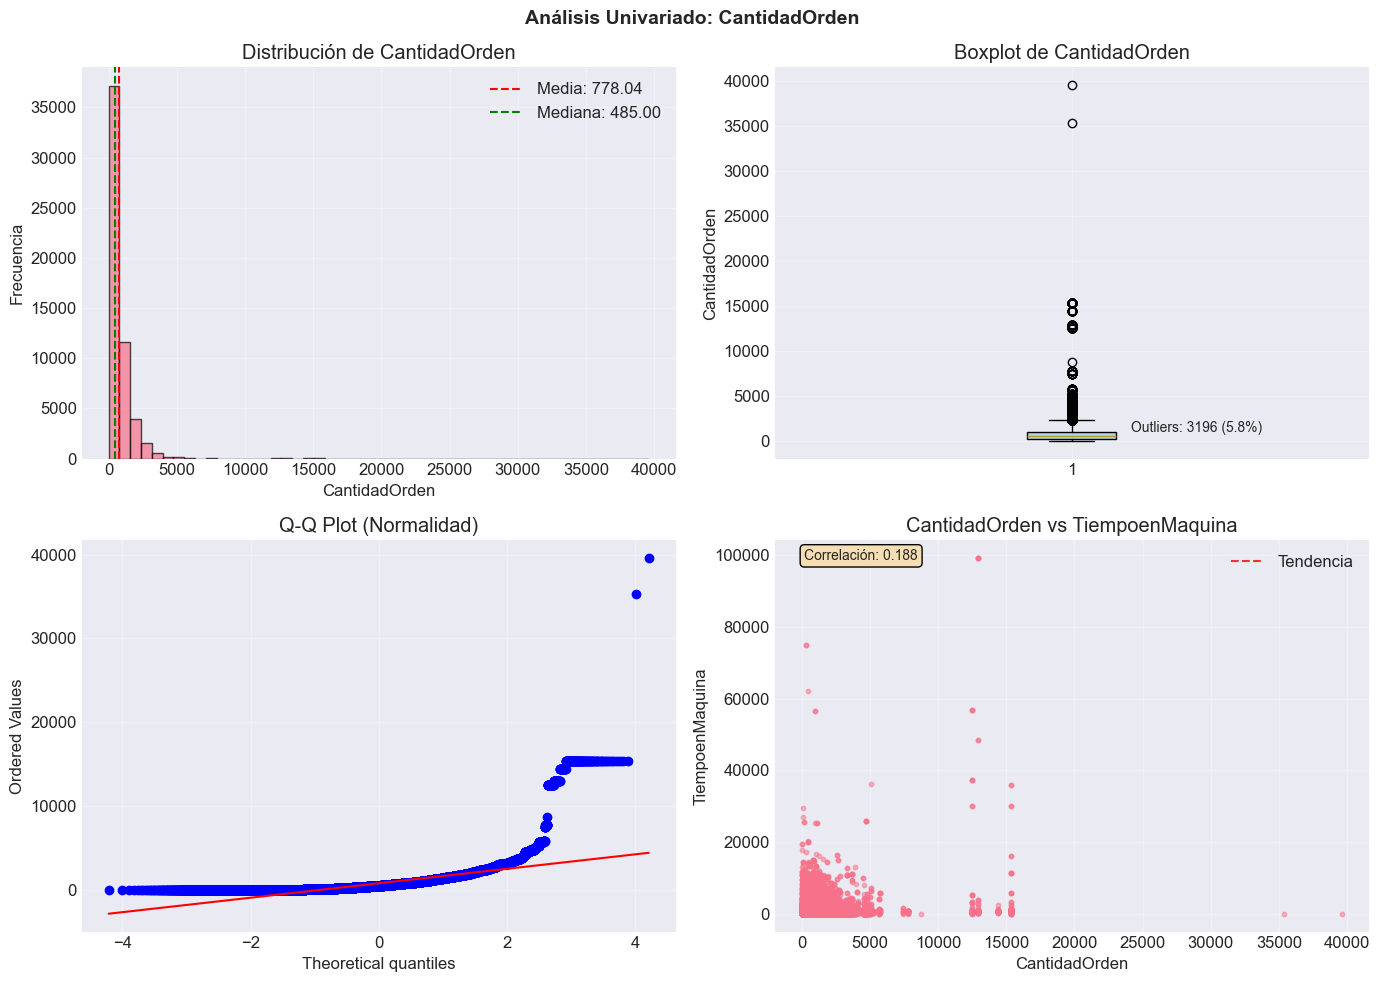

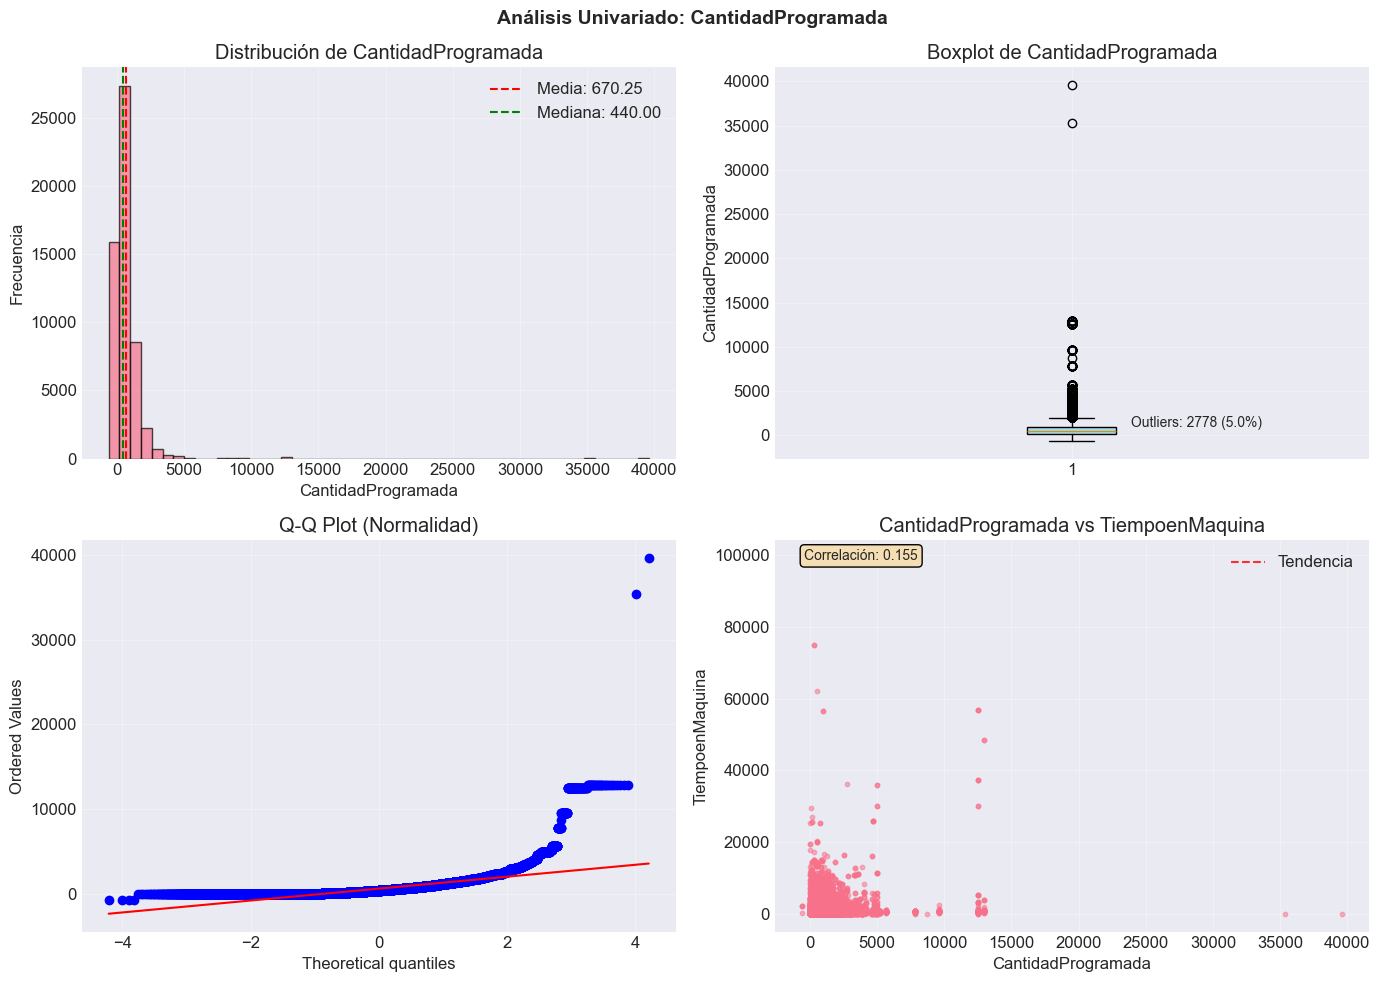

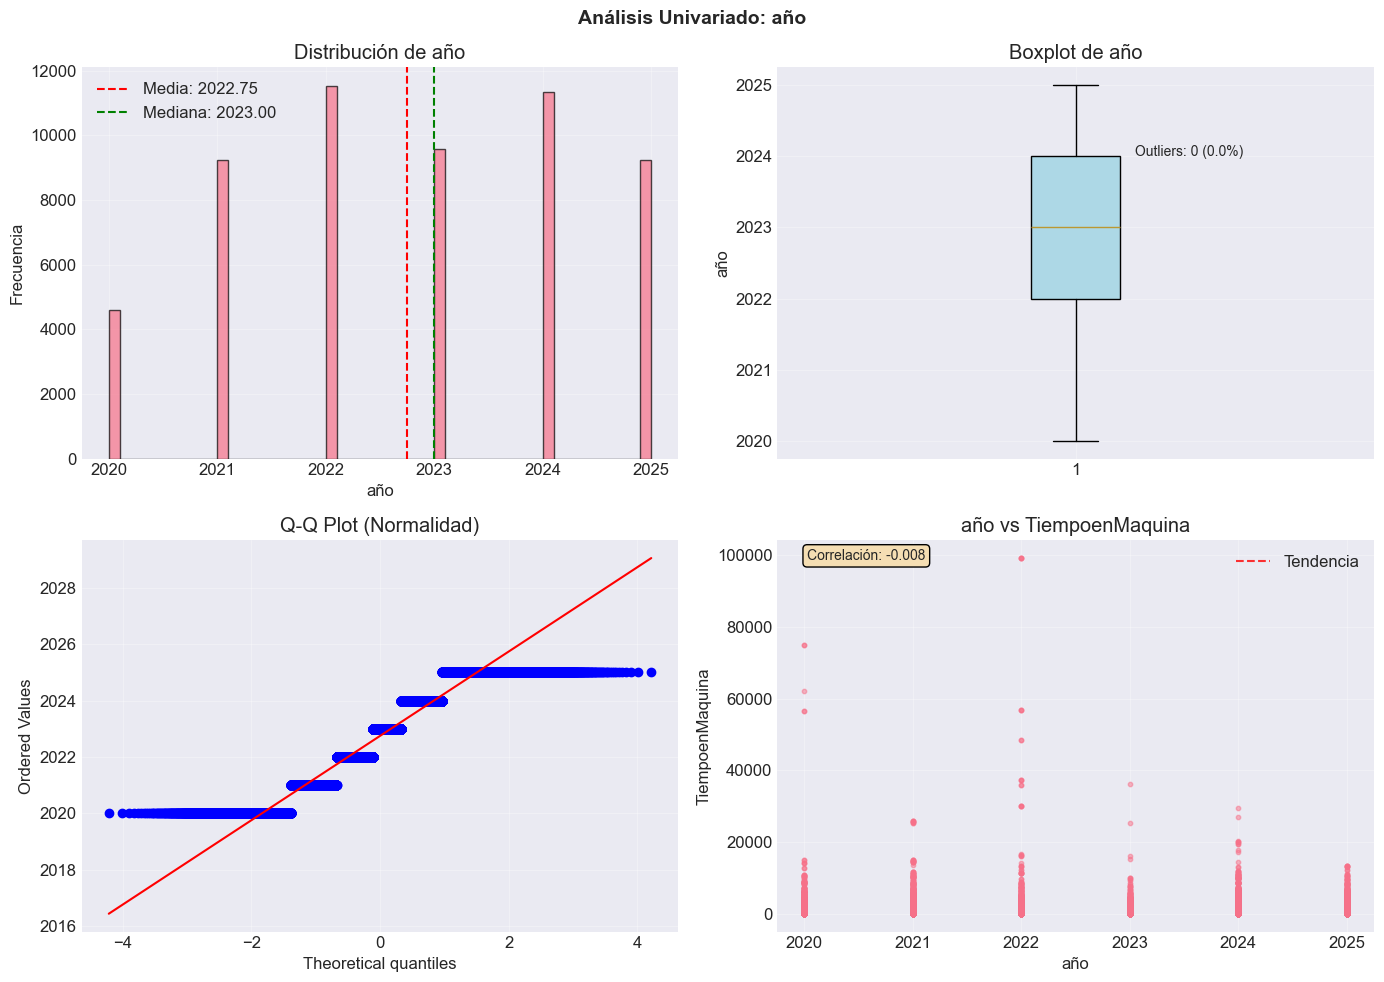

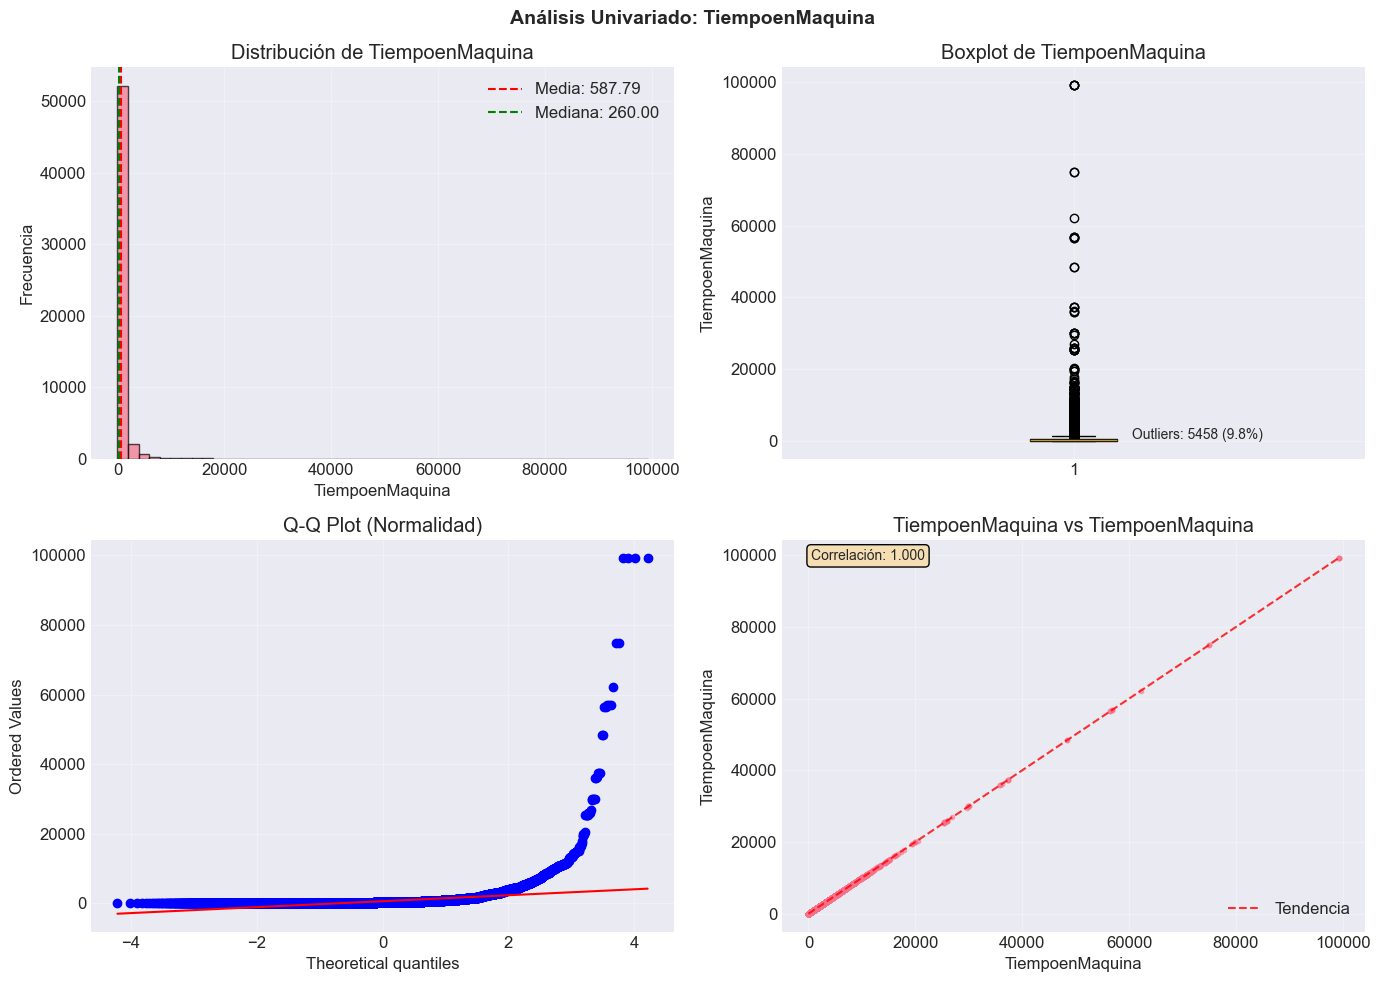

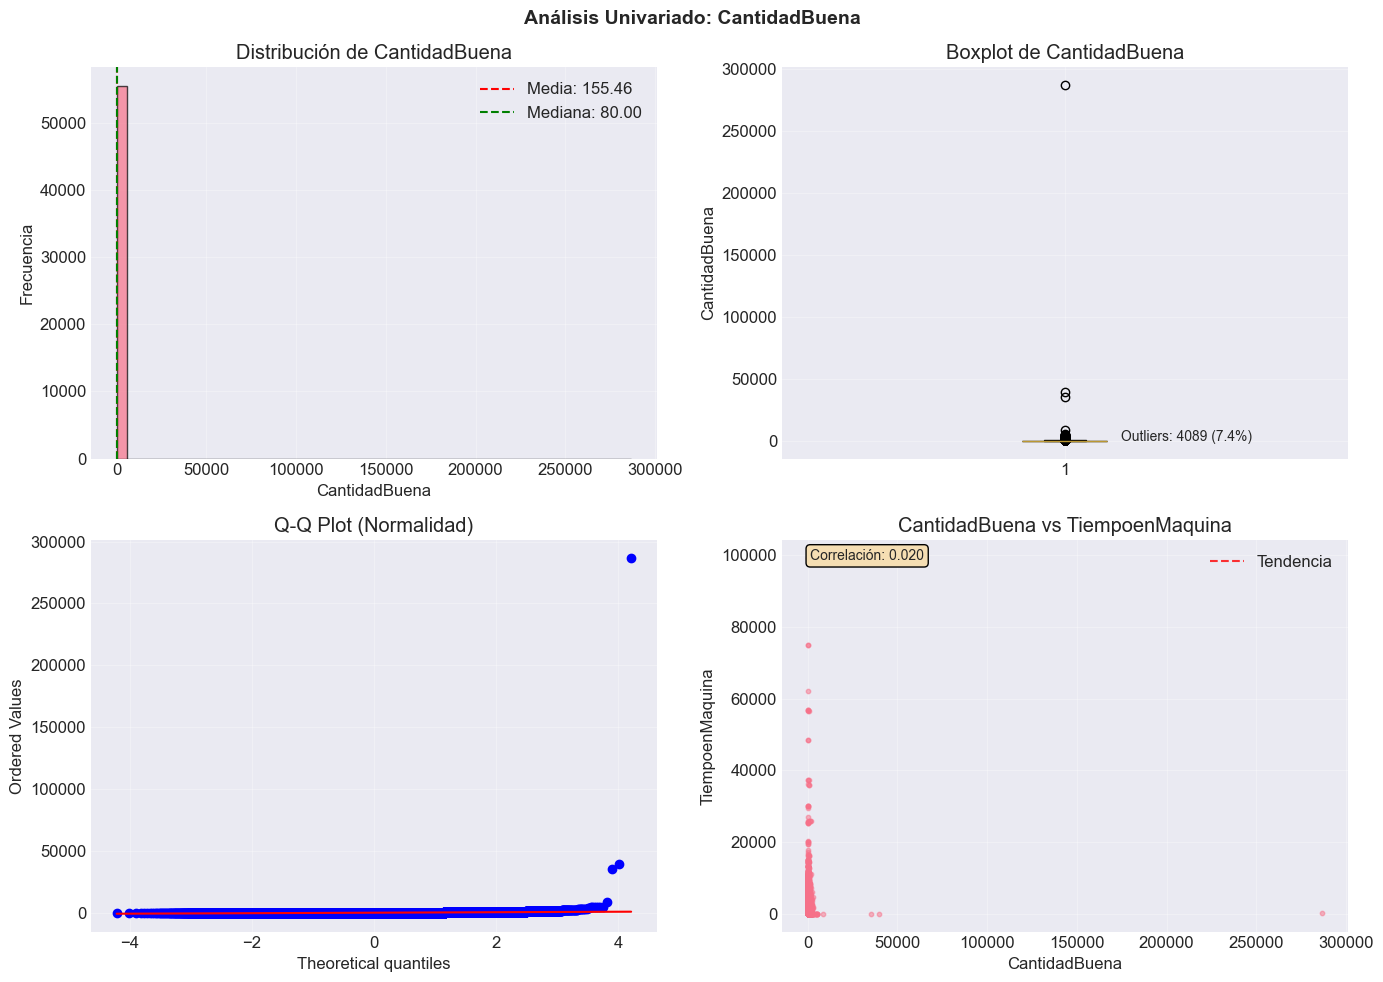

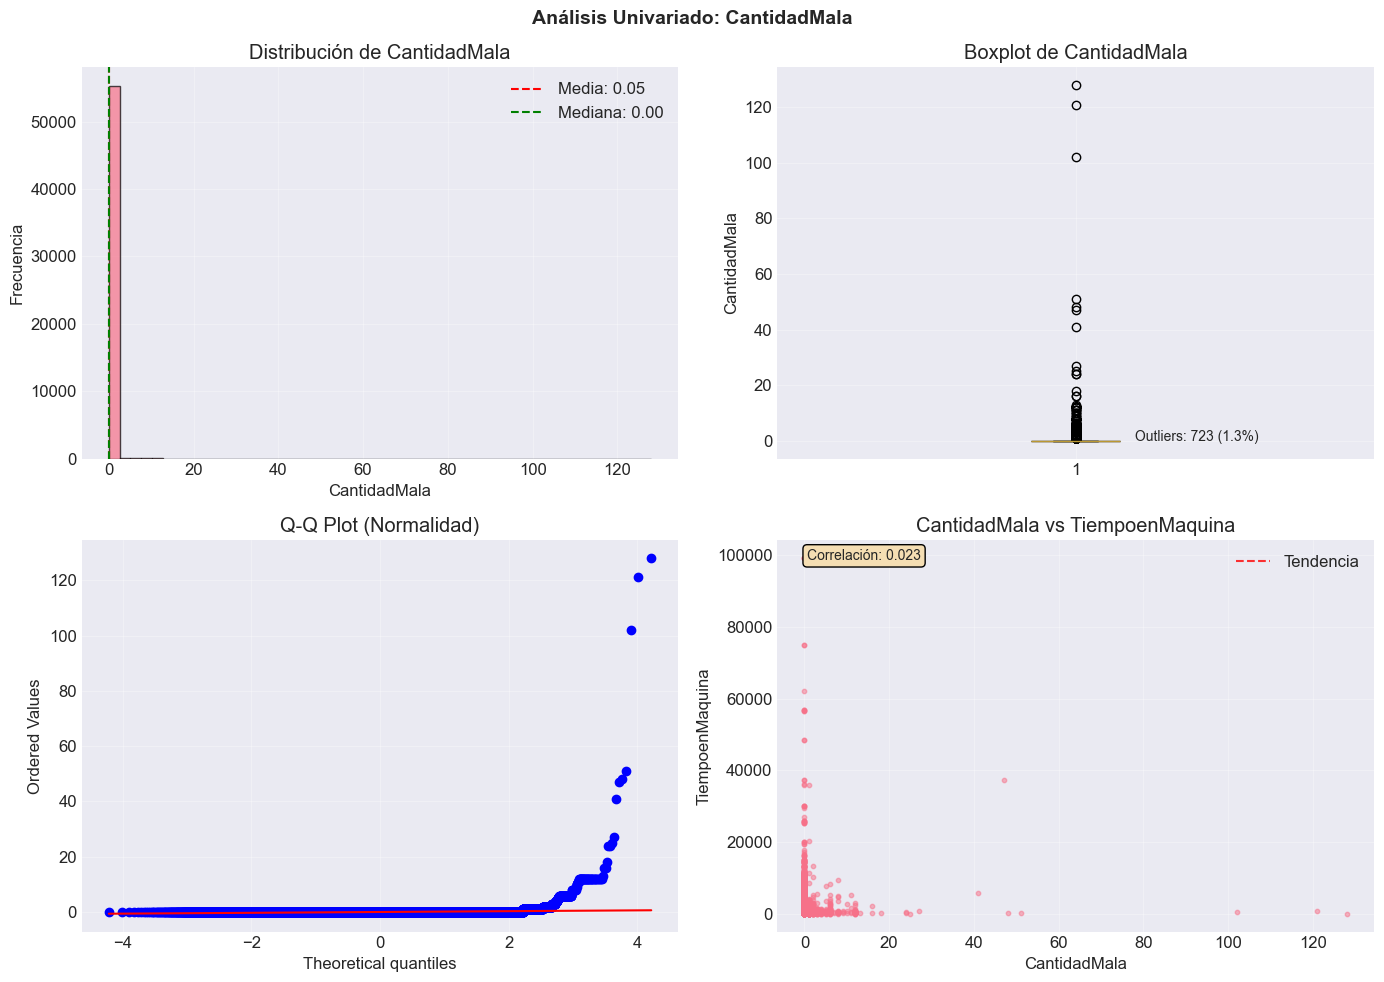

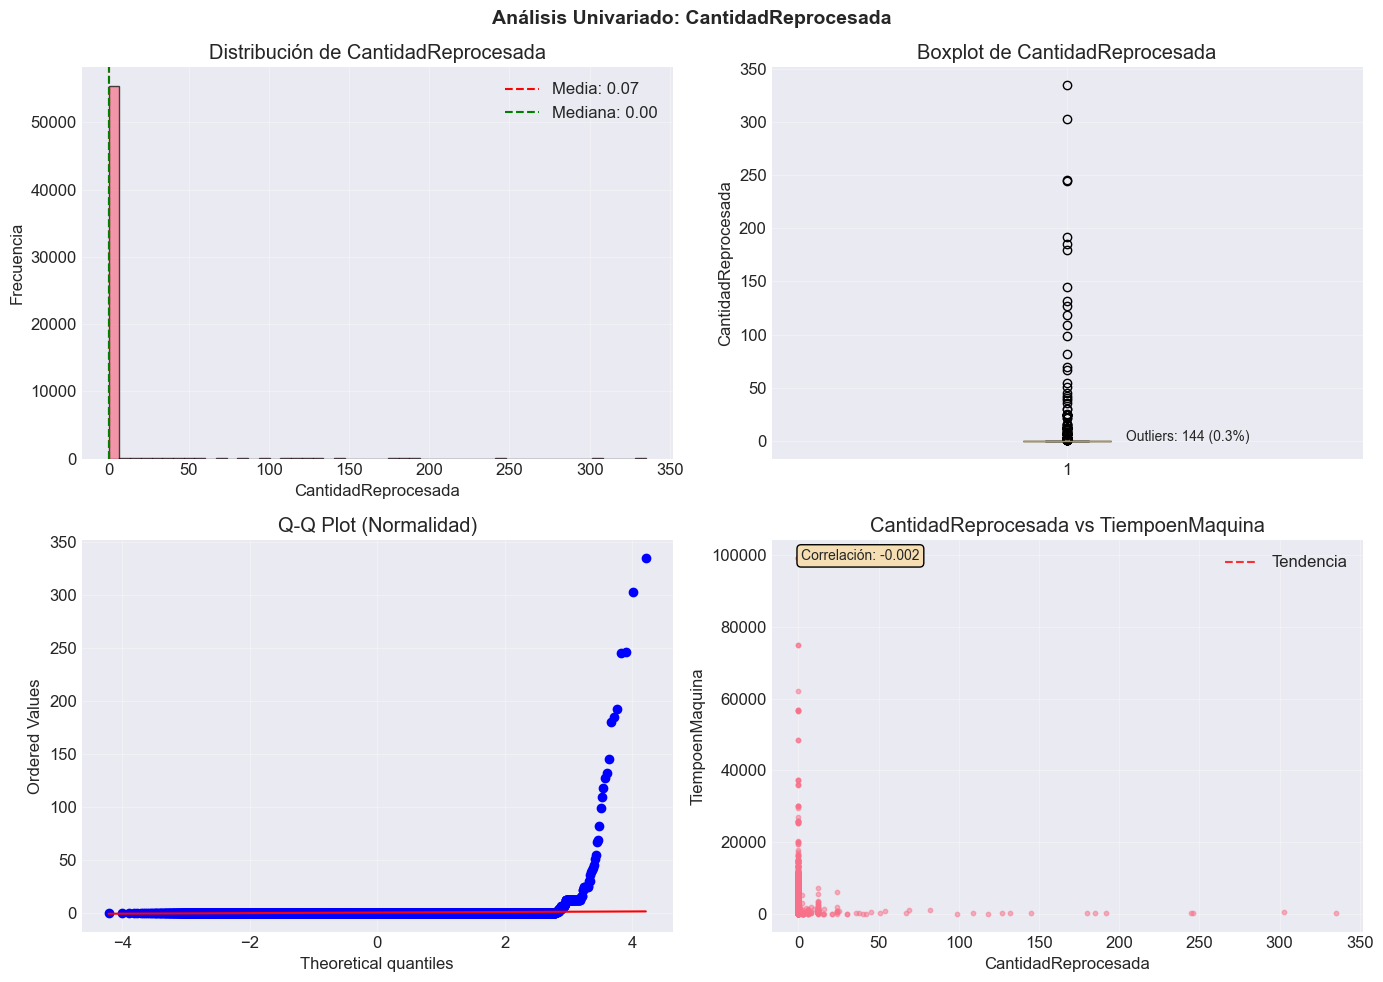

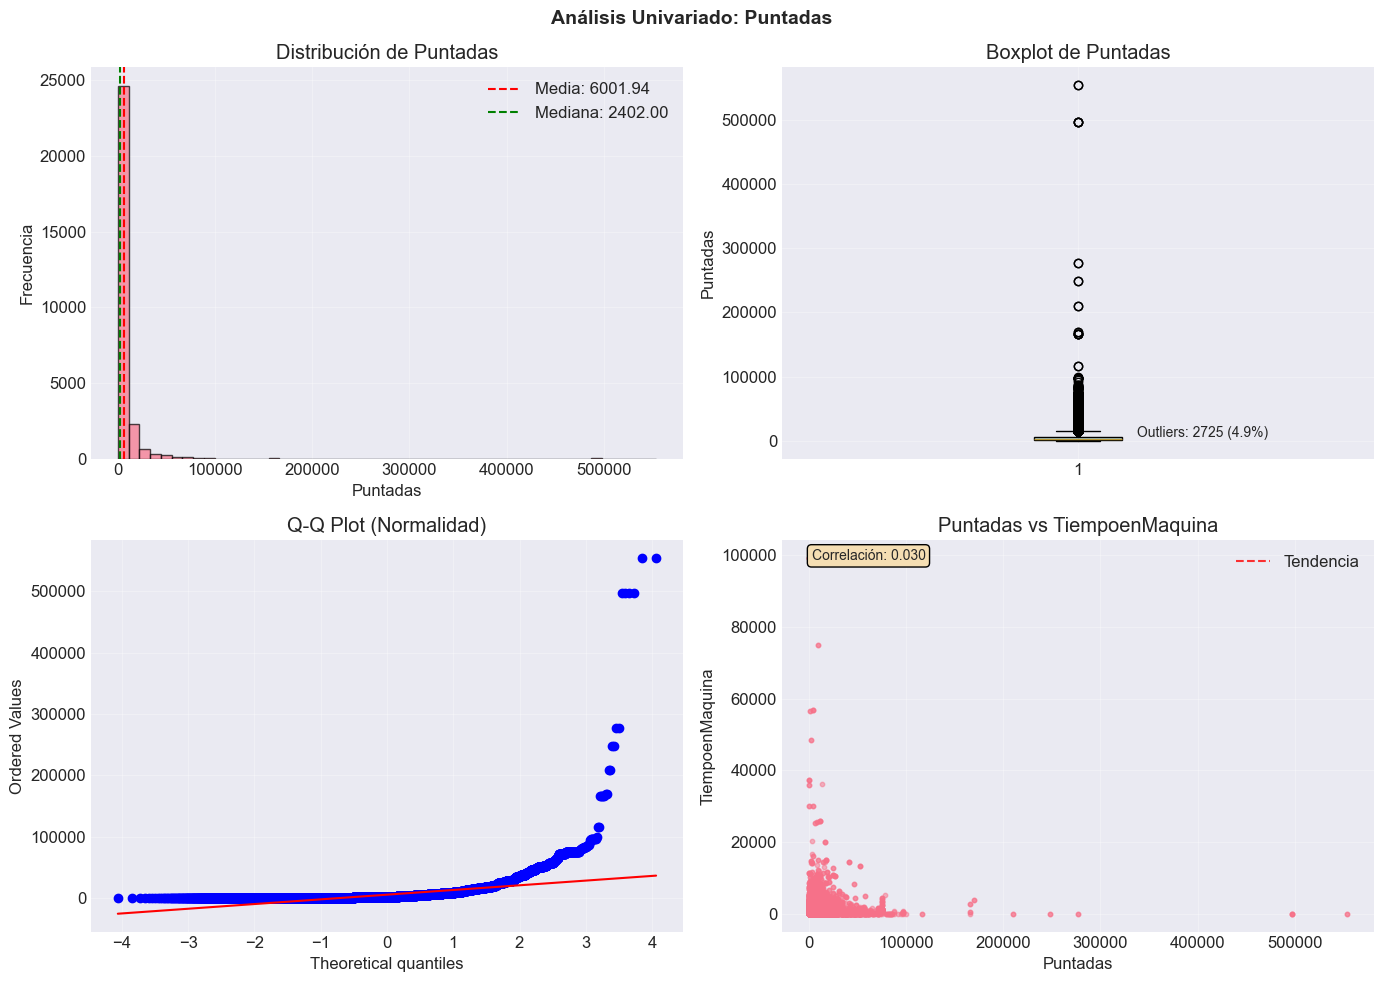

In [54]:
# Función para análisis univariado robusto
def univariate_analysis(df, column, target=None):
    """Análisis univariado con estadísticas robustas"""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Histograma con KDE
    ax1 = axes[0, 0]
    df[column].hist(bins=50, edgecolor='black', alpha=0.7, ax=ax1)
    ax1.axvline(df[column].mean(), color='red', linestyle='--', label=f'Media: {df[column].mean():.2f}')
    ax1.axvline(df[column].median(), color='green', linestyle='--', label=f'Mediana: {df[column].median():.2f}')
    ax1.set_title(f'Distribución de {column}')
    ax1.set_xlabel(column)
    ax1.set_ylabel('Frecuencia')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # 2. Boxplot
    ax2 = axes[0, 1]
    bp = ax2.boxplot(df[column].dropna(), vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    ax2.set_title(f'Boxplot de {column}')
    ax2.set_ylabel(column)
    ax2.grid(alpha=0.3)
    
    # Detectar outliers
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[column] < Q1 - 1.5 * IQR) | (df[column] > Q3 + 1.5 * IQR)]
    ax2.text(1.1, Q3, f'Outliers: {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)', 
             fontsize=10)
    
    # 3. Q-Q Plot
    ax3 = axes[1, 0]
    from scipy import stats
    stats.probplot(df[column].dropna(), dist="norm", plot=ax3)
    ax3.set_title('Q-Q Plot (Normalidad)')
    ax3.grid(alpha=0.3)
    
    # 4. Relación con target (si existe)
    ax4 = axes[1, 1]
    if target is not None and target in df.columns:
        ax4.scatter(df[column], df[target], alpha=0.5, s=10)
        ax4.set_xlabel(column)
        ax4.set_ylabel(target)
        ax4.set_title(f'{column} vs {target}')
        
        # Agregar línea de tendencia
        z = np.polyfit(df[column].dropna(), df[target][df[column].notna()], 1)
        p = np.poly1d(z)
        ax4.plot(df[column].sort_values(), p(df[column].sort_values()), 
                "r--", alpha=0.8, label=f'Tendencia')
        
        # Calcular correlación
        corr = df[column].corr(df[target])
        ax4.text(0.05, 0.95, f'Correlación: {corr:.3f}', 
                transform=ax4.transAxes, fontsize=10,
                bbox=dict(boxstyle='round', facecolor='wheat'))
        ax4.legend()
    else:
        # Estadísticas adicionales
        ax4.axis('off')
        stats_text = f"""
        Estadísticas Robustas:
        
        • Media: {df[column].mean():.2f}
        • Mediana: {df[column].median():.2f}
        • Desv. Estándar: {df[column].std():.2f}
        • MAD: {stats.median_abs_deviation(df[column].dropna()):.2f}
        • Asimetría: {df[column].skew():.2f}
        • Curtosis: {df[column].kurtosis():.2f}
        • Rango: [{df[column].min():.2f}, {df[column].max():.2f}]
        • IQR: {IQR:.2f}
        • CV: {df[column].std()/df[column].mean():.2f}
        """
        ax4.text(0.1, 0.5, stats_text, transform=ax4.transAxes, 
                fontsize=11, verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
    
    ax4.grid(alpha=0.3)
    
    plt.suptitle(f'Análisis Univariado: {column}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Analizar variables numéricas clave
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

cols_id = ["PedidoId", "MaterialIdOrden", "MaterialId", "HiloInferiorId"]
target = "TiempoenMaquina"

numeric_cols_model = [
    c for c in numeric_cols
    if c not in cols_id  # quitar IDs
]

print("Columnas numéricas para análisis univariado:")
print(numeric_cols_model)

# 2) Aplicar la función de análisis univariado
for col in numeric_cols_model:
    univariate_analysis(df, col, target=target)

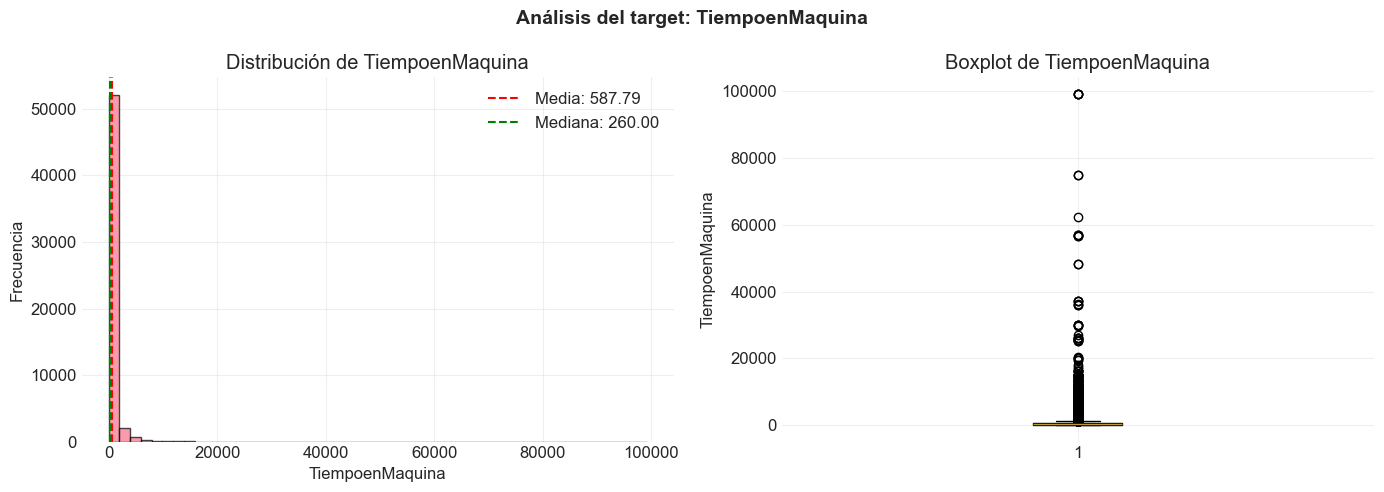

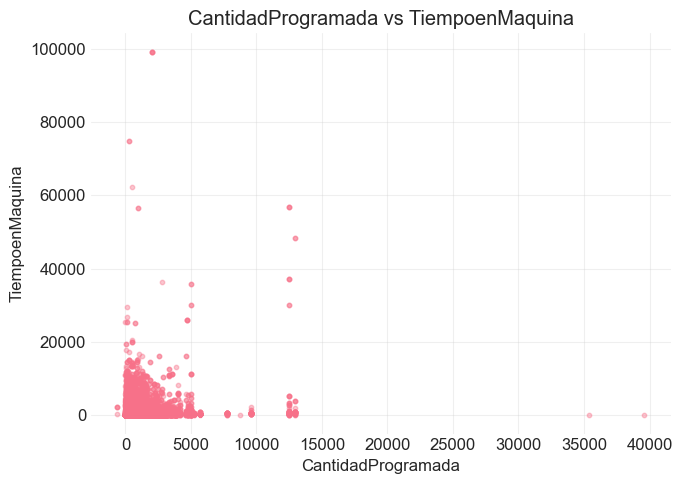

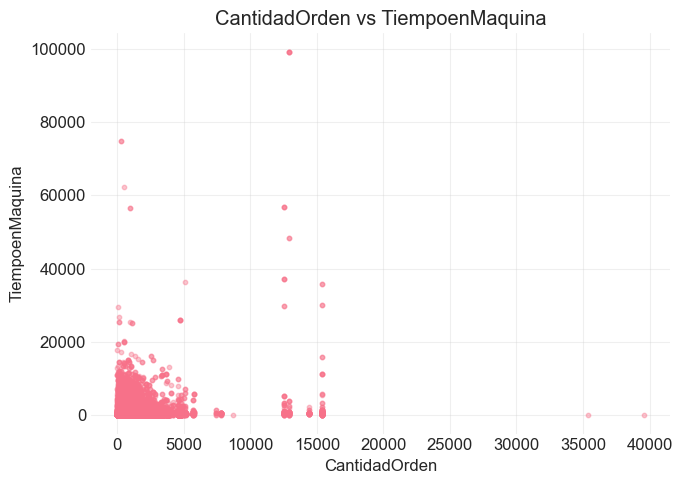

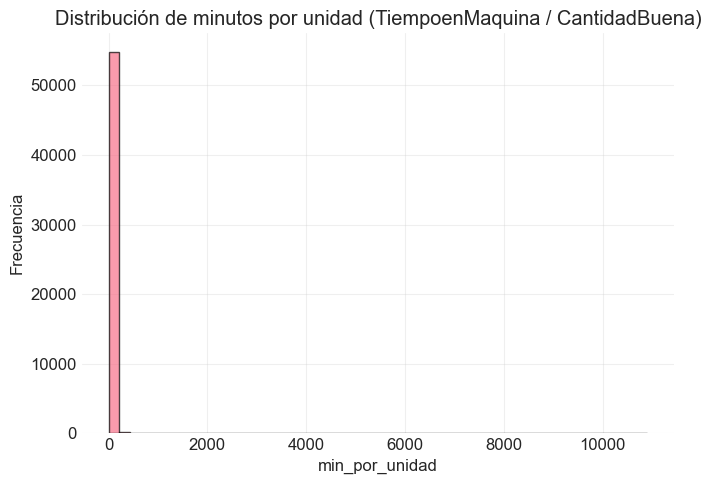

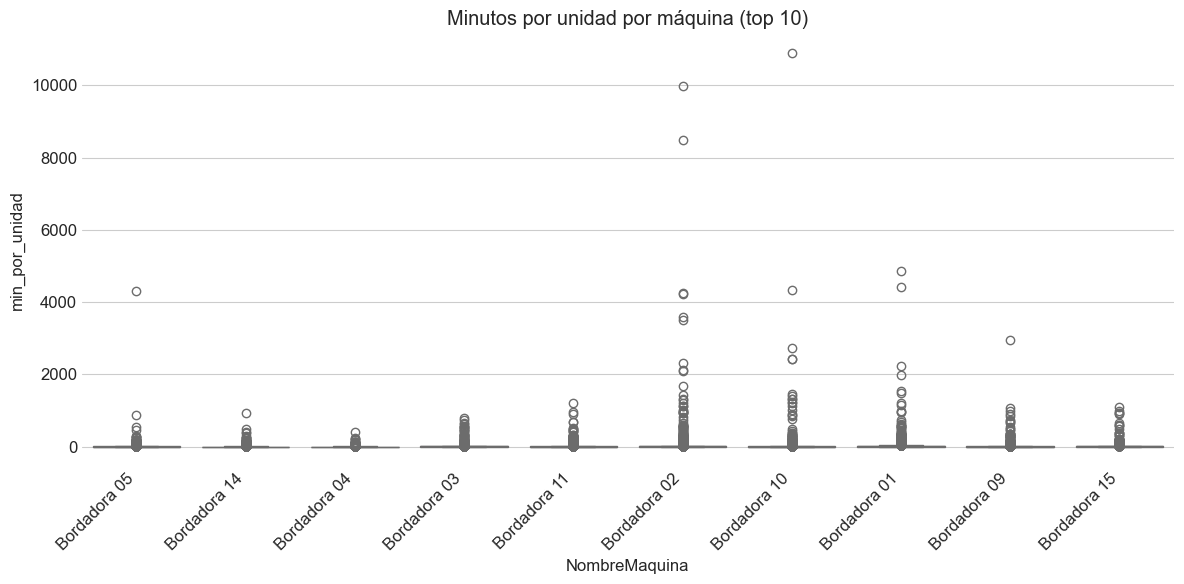

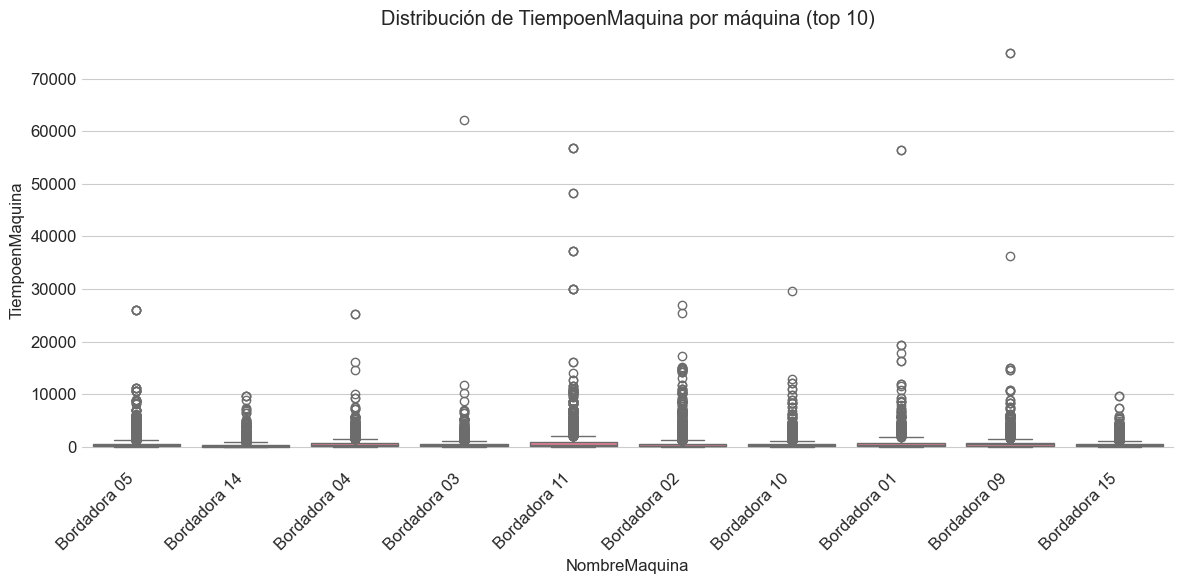

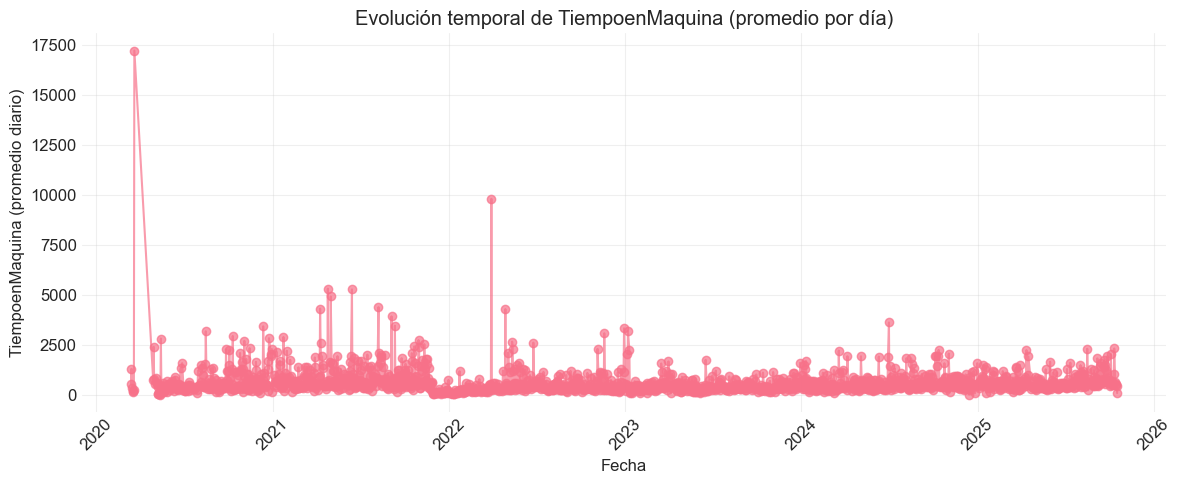

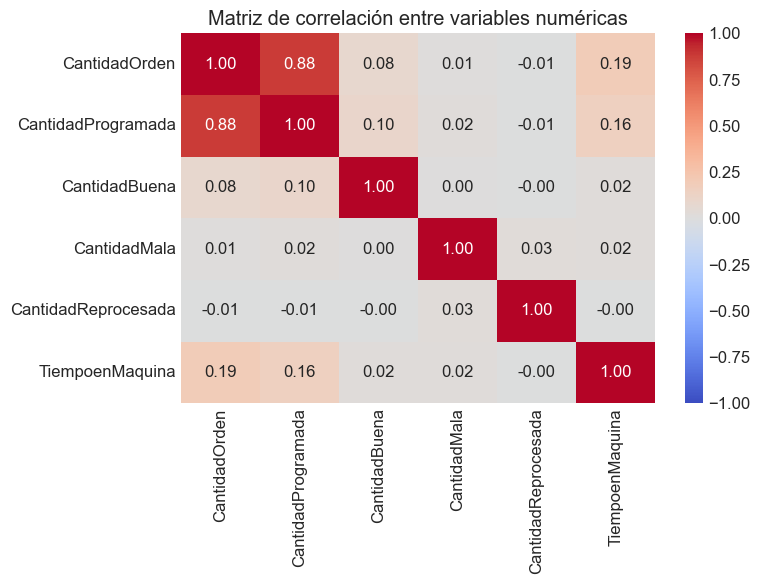

EDA finalizado ✅


In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def eda_produccion(df, target_col="TiempoenMaquina", total_time_col="tiempo_total_min"):
    """
    EDA para el dataset de producción.
    Hace:
      - Distribución del target y tiempo total
      - Volumen vs tiempo (CantidadProgramada / CantidadOrden)
      - Minutos por unidad y distribución por máquina
      - Boxplot de tiempo por máquina
      - Serie temporal del tiempo promedio
      - Matriz de correlación de variables numéricas clave
    """

    sns.set_style("whitegrid")

    # Copia para no tocar el original
    data = df.copy()

    # =========================
    # 1. Distribución del target
    # =========================
    if target_col in data.columns:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Histograma
        axes[0].hist(data[target_col].dropna(), bins=50, edgecolor="black", alpha=0.7)
        axes[0].axvline(data[target_col].mean(), color="red", linestyle="--",
                        label=f"Media: {data[target_col].mean():.2f}")
        axes[0].axvline(data[target_col].median(), color="green", linestyle="--",
                        label=f"Mediana: {data[target_col].median():.2f}")
        axes[0].set_title(f"Distribución de {target_col}")
        axes[0].set_xlabel(target_col)
        axes[0].set_ylabel("Frecuencia")
        axes[0].legend()
        axes[0].grid(alpha=0.3)

        # Boxplot
        axes[1].boxplot(data[target_col].dropna(), vert=True, patch_artist=True)
        axes[1].set_title(f"Boxplot de {target_col}")
        axes[1].set_ylabel(target_col)
        axes[1].grid(alpha=0.3)

        plt.suptitle(f"Análisis del target: {target_col}", fontsize=14, fontweight="bold")
        plt.tight_layout()
        plt.show()

    # Distribución de tiempo_total_min (si existe)
    if total_time_col in data.columns:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        axes[0].hist(data[total_time_col].dropna(), bins=50, edgecolor="black", alpha=0.7)
        axes[0].set_title(f"Distribución de {total_time_col}")
        axes[0].set_xlabel(total_time_col)
        axes[0].set_ylabel("Frecuencia")
        axes[0].grid(alpha=0.3)

        axes[1].boxplot(data[total_time_col].dropna(), vert=True, patch_artist=True)
        axes[1].set_title(f"Boxplot de {total_time_col}")
        axes[1].set_ylabel(total_time_col)
        axes[1].grid(alpha=0.3)

        plt.suptitle(f"Tiempo total (si disponible): {total_time_col}", fontsize=14, fontweight="bold")
        plt.tight_layout()
        plt.show()

    # ==================================
    # 2. Volumen vs tiempo (scatterplots)
    # ==================================
    for vol_col in ["CantidadProgramada", "CantidadOrden"]:
        if vol_col in data.columns and target_col in data.columns:
            plt.figure(figsize=(7, 5))
            plt.scatter(data[vol_col], data[target_col], alpha=0.4, s=10)
            plt.xlabel(vol_col)
            plt.ylabel(target_col)
            plt.title(f"{vol_col} vs {target_col}")
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()

    # =======================================
    # 3. Minutos por unidad y por máquina
    # =======================================
    if target_col in data.columns and "CantidadBuena" in data.columns:
        data["min_por_unidad"] = data[target_col] / data["CantidadBuena"].replace(0, np.nan)

        # Histograma de min_por_unidad
        plt.figure(figsize=(7, 5))
        plt.hist(data["min_por_unidad"].dropna(), bins=50, edgecolor="black", alpha=0.7)
        plt.title("Distribución de minutos por unidad (TiempoenMaquina / CantidadBuena)")
        plt.xlabel("min_por_unidad")
        plt.ylabel("Frecuencia")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Boxplot por máquina (top 10)
        if "NombreMaquina" in data.columns:
            top_machines = data["NombreMaquina"].value_counts().head(10).index
            plt.figure(figsize=(12, 6))
            sns.boxplot(
                data=data[data["NombreMaquina"].isin(top_machines)],
                x="NombreMaquina", y="min_por_unidad"
            )
            plt.xticks(rotation=45, ha="right")
            plt.title("Minutos por unidad por máquina (top 10)")
            plt.tight_layout()
            plt.show()

    # ==========================================
    # 4. Boxplot del tiempo por NombreMaquina
    # ==========================================
    if target_col in data.columns and "NombreMaquina" in data.columns:
        top_machines = data["NombreMaquina"].value_counts().head(10).index
        plt.figure(figsize=(12, 6))
        sns.boxplot(
            data=data[data["NombreMaquina"].isin(top_machines)],
            x="NombreMaquina", y=target_col
        )
        plt.xticks(rotation=45, ha="right")
        plt.title(f"Distribución de {target_col} por máquina (top 10)")
        plt.tight_layout()
        plt.show()

    # ================================
    # 5. Serie temporal del tiempo medio
    # ================================
    if "FechaInicio" in data.columns and target_col in data.columns:
        fechas = pd.to_datetime(data["FechaInicio"], errors="coerce")
        data["_fecha"] = fechas.dt.date

        daily = (
            data
            .dropna(subset=["_fecha", target_col])
            .groupby("_fecha")[target_col]
            .mean()
            .reset_index()
        )

        if not daily.empty:
            plt.figure(figsize=(12, 5))
            plt.plot(daily["_fecha"], daily[target_col], marker="o", linestyle="-", alpha=0.7)
            plt.xlabel("Fecha")
            plt.ylabel(f"{target_col} (promedio diario)")
            plt.title(f"Evolución temporal de {target_col} (promedio por día)")
            plt.xticks(rotation=45)
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()

    # =====================================
    # 6. Matriz de correlación de numéricas
    # =====================================
    candidate_num_cols = [
        "CantidadOrden", "CantidadProgramada",
        "CantidadBuena", "CantidadMala", "CantidadReprocesada",
        target_col
    ]
    num_cols_corr = [c for c in candidate_num_cols if c in data.columns]

    if len(num_cols_corr) >= 2:
        corr = data[num_cols_corr].corr()

        plt.figure(figsize=(8, 6))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
        plt.title("Matriz de correlación entre variables numéricas")
        plt.tight_layout()
        plt.show()

    print("EDA finalizado ✅")

eda_produccion(df)


=== Análisis categórico: NombreMaquina vs TiempoenMaquina ===


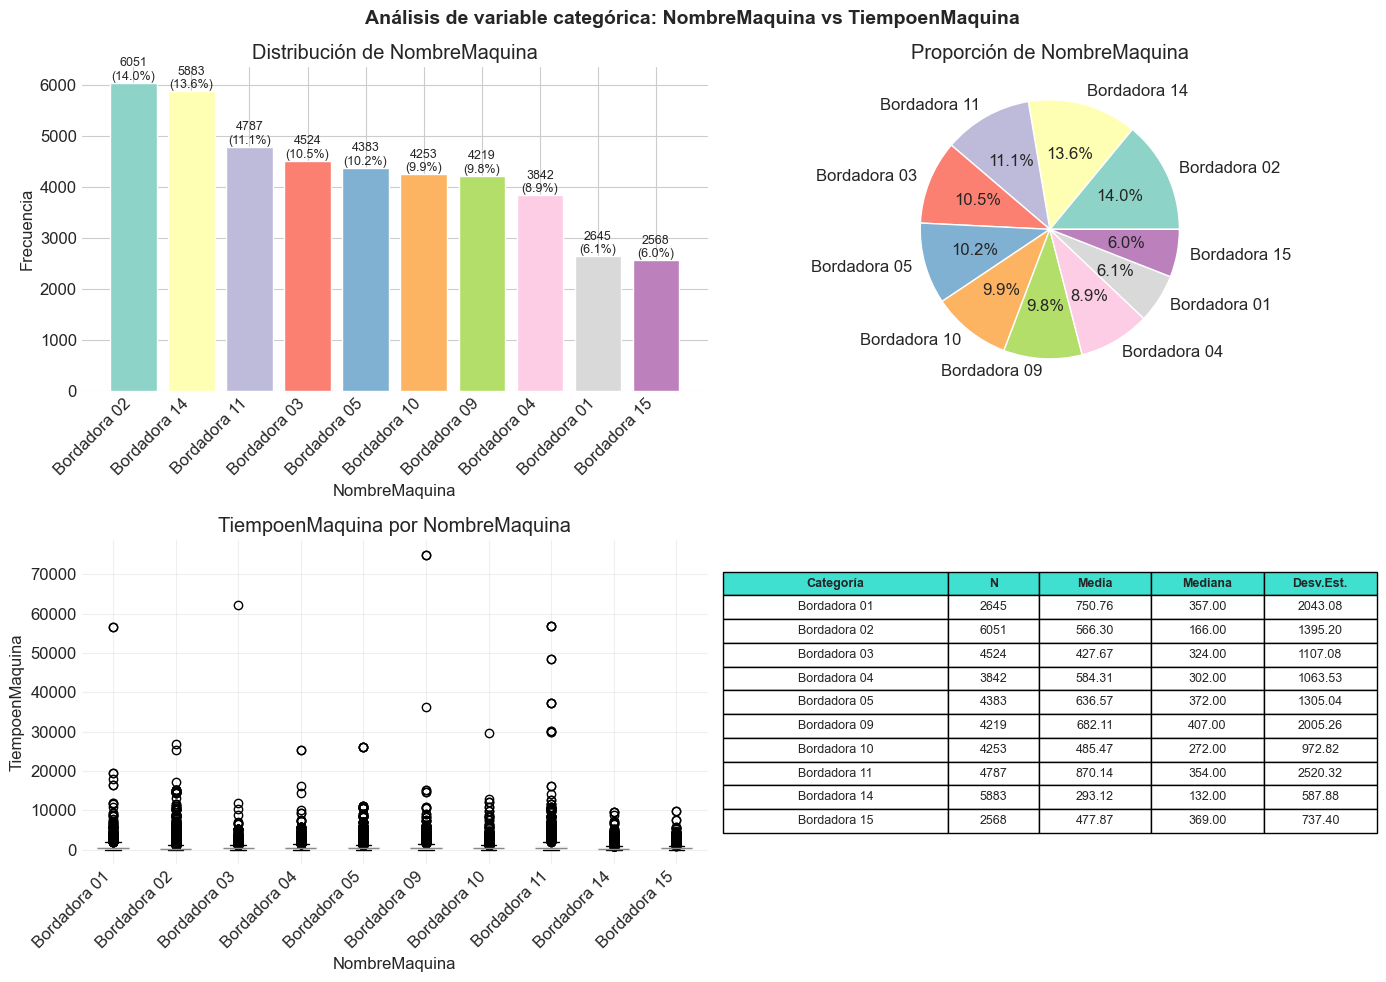


=== Análisis categórico: Operario vs TiempoenMaquina ===


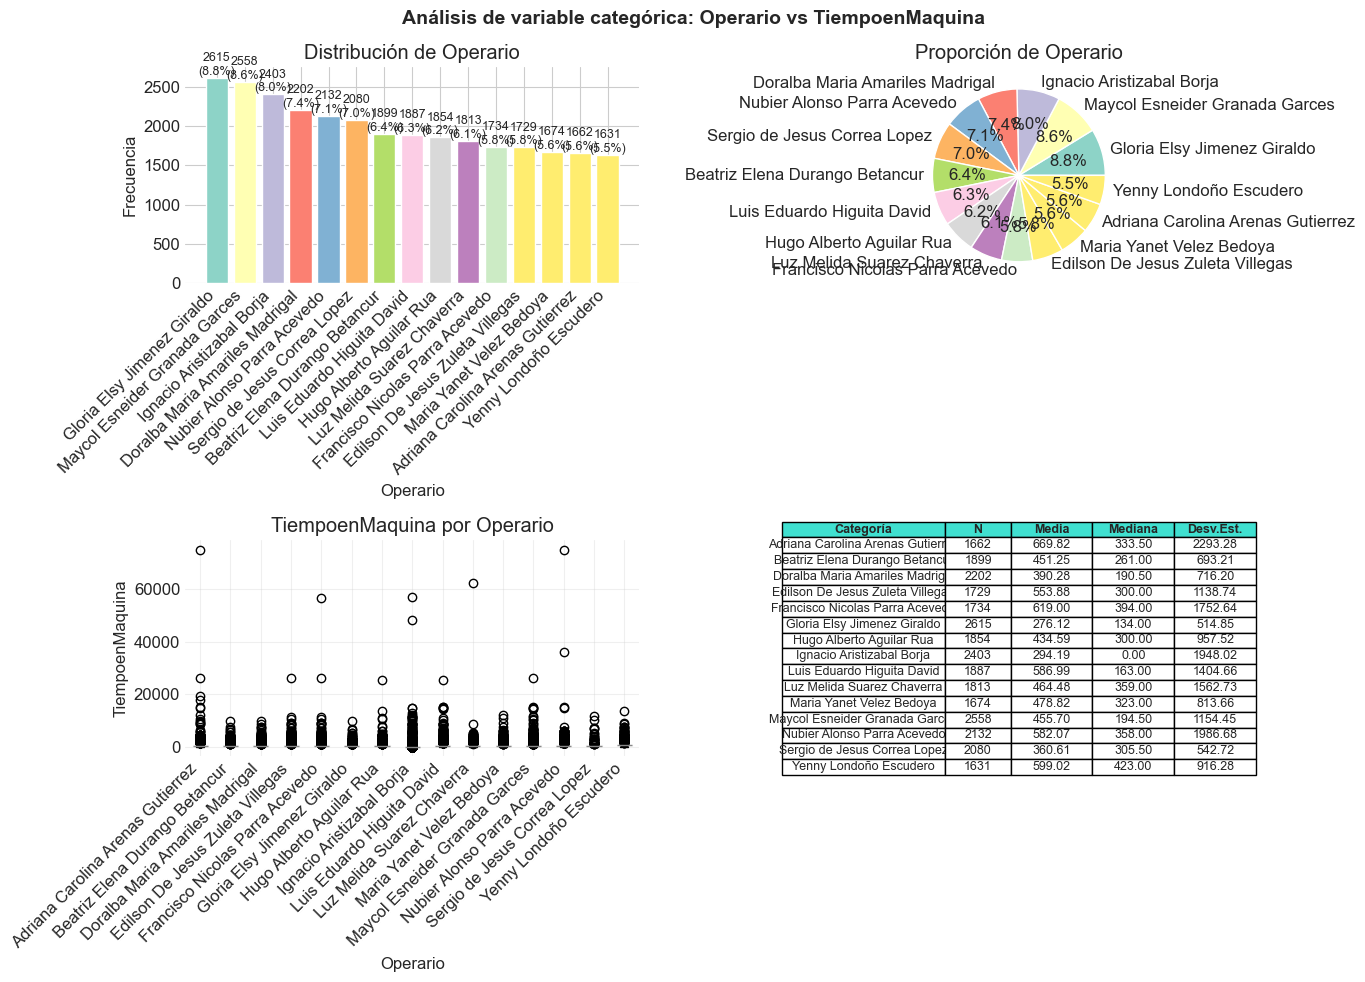


=== Análisis categórico: codigoMaterial vs TiempoenMaquina ===


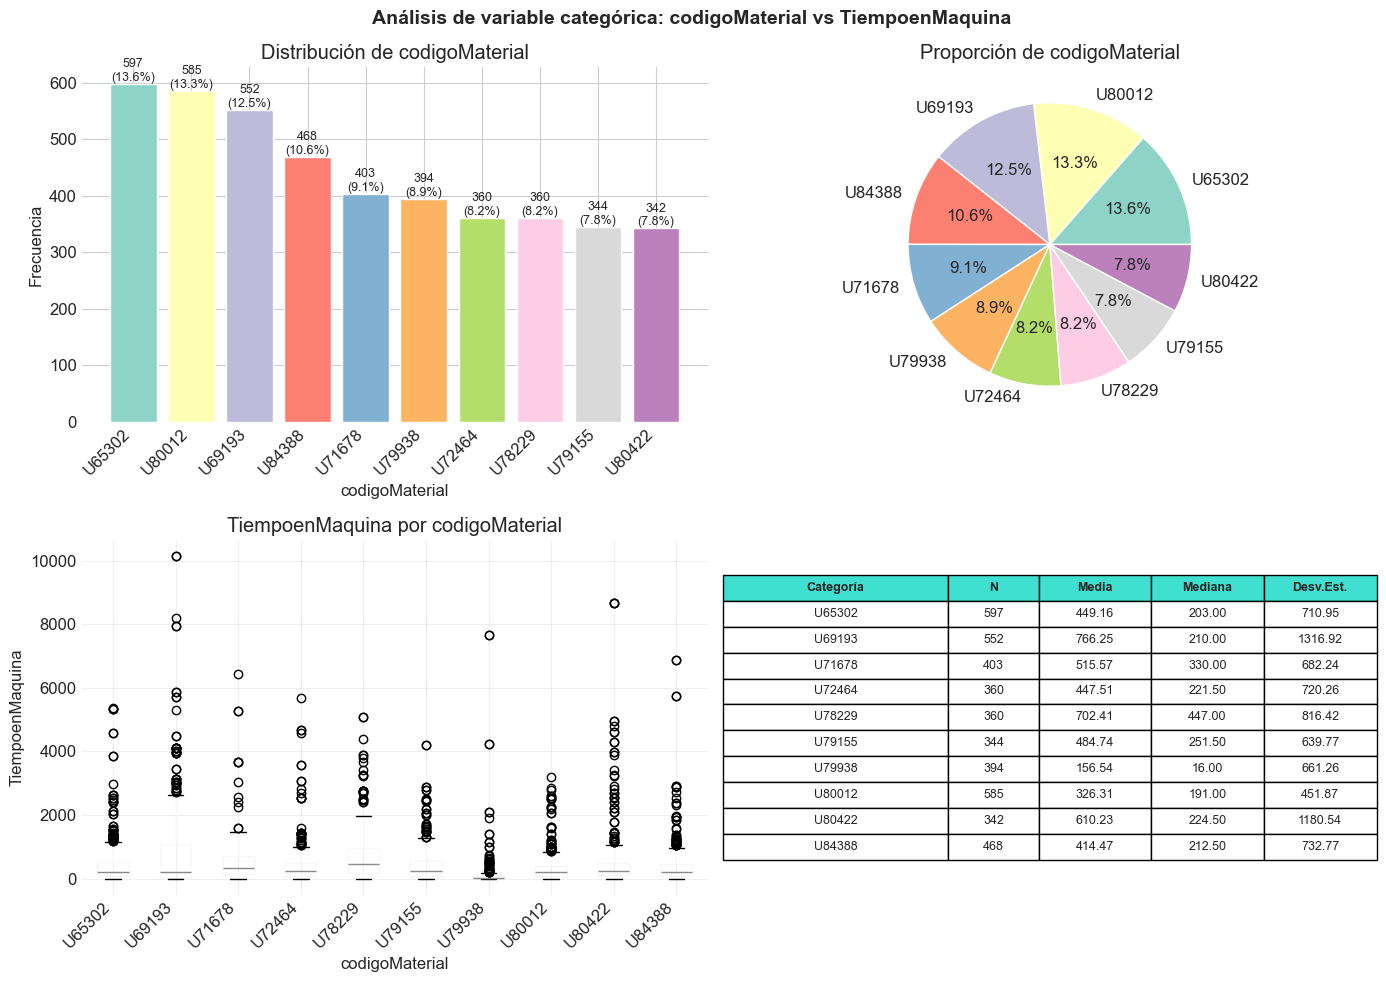


=== Análisis categórico: dia_semana vs TiempoenMaquina ===


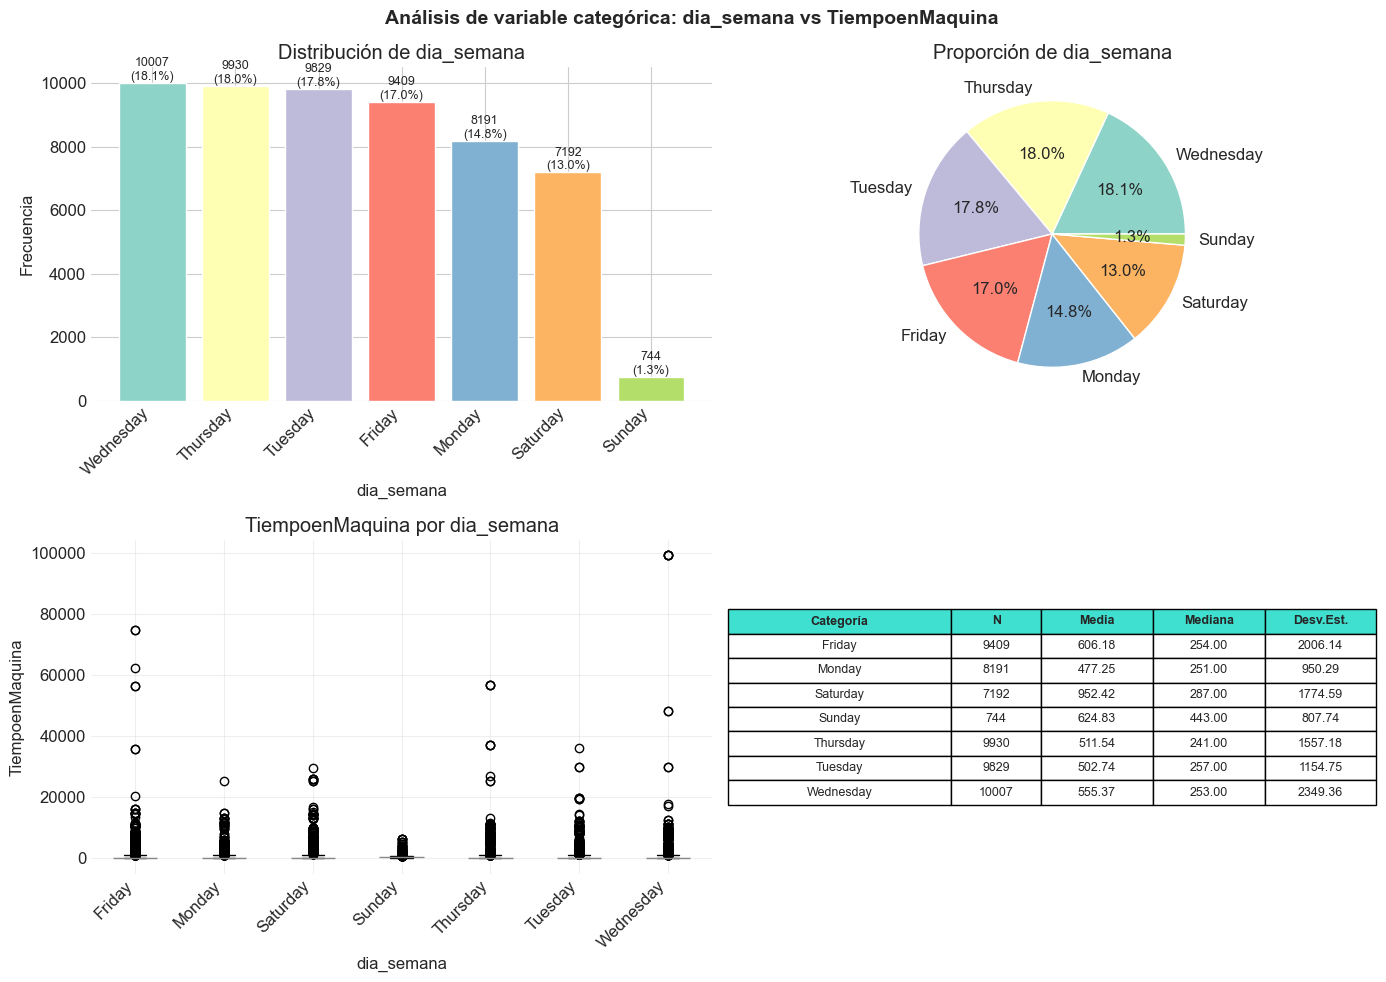


=== Análisis categórico: turno vs TiempoenMaquina ===


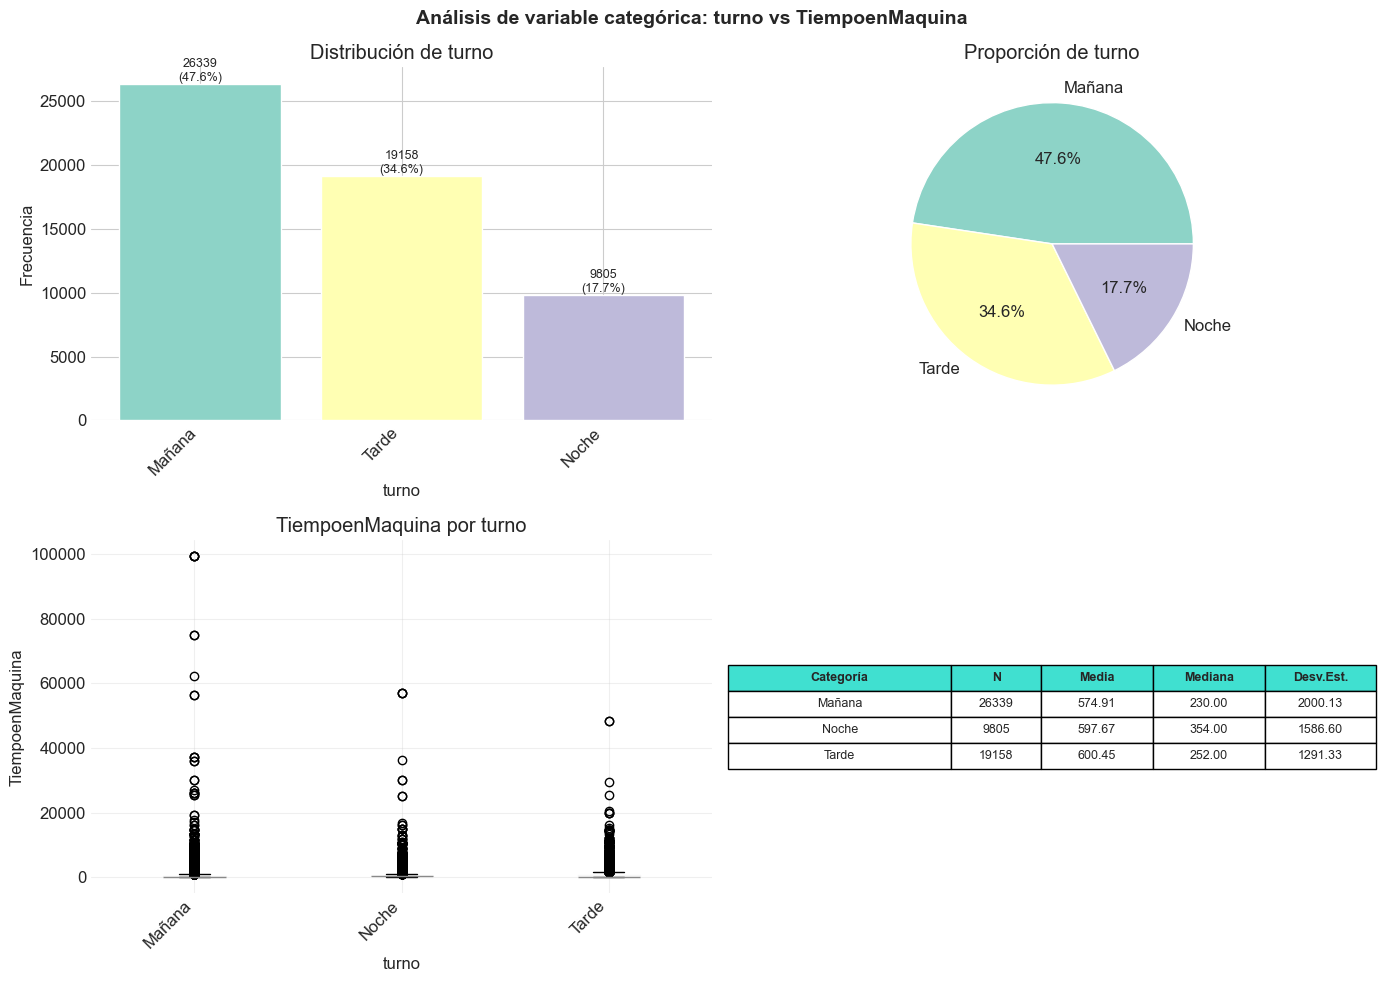


EDA de variables categóricas finalizado ✅


In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def eda_categoricas_produccion(df, target_col="TiempoenMaquina"):
    """
    EDA de variables categóricas para el dataset de producción.

    Para cada variable categórica clave genera:
      - Barras (conteos + %)
      - Pie chart
      - Boxplot del target por categoría
      - Tabla de stats (N, media, mediana, desv.est.)

    Categóricas analizadas:
      - NombreMaquina (top 10)
      - Operario (top 15, solo nombres)
      - codigoMaterial (top 10)
      - dia_semana (derivada de FechaInicio, si existe)
      - turno (Mañana/Tarde/Noche, derivado de FechaInicio, si existe)
    """

    data = df.copy()

    # ===============================
    # Derivadas de fecha: dia_semana y turno
    # ===============================
    if "FechaInicio" in data.columns:
        data["FechaInicio_dt"] = pd.to_datetime(data["FechaInicio"], errors="coerce")
        data["dia_semana"] = data["FechaInicio_dt"].dt.day_name()
        data["hora"] = data["FechaInicio_dt"].dt.hour

        def clasificar_turno(h):
            if pd.isna(h):
                return np.nan
            if 6 <= h < 14:
                return "Mañana"
            elif 14 <= h < 22:
                return "Tarde"
            else:
                return "Noche"

        data["turno"] = data["hora"].apply(clasificar_turno)

    # ===============================
    # Config de categóricas a analizar
    # ===============================
    cat_configs = [
        ("NombreMaquina", 10),
        ("Operario", 15),       # solo nombres, limpiados
        ("codigoMaterial", 10),
        ("dia_semana", None),
        ("turno", None),
    ]

    for cat_col, top_n in cat_configs:
        if cat_col not in data.columns:
            print(f"[INFO] Columna '{cat_col}' no existe en el DataFrame, se omite.")
            continue

        # Subconjunto con cat + target
        sub = data[[cat_col, target_col]].copy()

        # 1) Asegurar que la categórica esté como string limpio (especialmente Operario)
        sub[cat_col] = sub[cat_col].astype(str).str.strip()

        # 2) Quitar nulos del target y de la categórica
        sub = sub.replace("nan", np.nan)  # por si quedaron como texto
        sub = sub.dropna(subset=[cat_col, target_col])

        if sub.empty:
            print(f"[INFO] No hay datos válidos para {cat_col} vs {target_col}, se omite.")
            continue

        # Limitar a top_n categorías si aplica
        if top_n is not None:
            top_cats = sub[cat_col].value_counts().head(top_n).index
            sub = sub[sub[cat_col].isin(top_cats)]

        if sub.empty:
            print(f"[INFO] Después de filtrar top categorías, {cat_col} quedó vacío, se omite.")
            continue

        print(f"\n=== Análisis categórico: {cat_col} vs {target_col} ===")

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # ===============================
        # 1) Barras con conteos y porcentajes
        # ===============================
        ax1 = axes[0, 0]
        counts = sub[cat_col].value_counts()
        colors = plt.cm.Set3(range(len(counts)))

        x_pos = np.arange(len(counts))
        ax1.bar(x_pos, counts.values, color=colors)
        ax1.set_title(f"Distribución de {cat_col}")
        ax1.set_xlabel(cat_col)
        ax1.set_ylabel("Frecuencia")

        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(counts.index, rotation=45, ha="right")

        total = len(sub)
        for i, (idx, val) in enumerate(counts.items()):
            ax1.text(i, val, f"{val}\n({val/total*100:.1f}%)",
                     ha="center", va="bottom", fontsize=9)

        # ===============================
        # 2) Pie chart
        # ===============================
        ax2 = axes[0, 1]
        ax2.pie(
            counts.values,
            labels=counts.index,
            autopct="%1.1f%%",
            colors=colors
        )
        ax2.set_title(f"Proporción de {cat_col}")

        # ===============================
        # 3) Boxplot del target por categoría
        # ===============================
        ax3 = axes[1, 0]
        sub.boxplot(column=target_col, by=cat_col, ax=ax3)
        ax3.set_title(f"{target_col} por {cat_col}")
        ax3.set_xlabel(cat_col)
        ax3.set_ylabel(target_col)
        plt.sca(ax3)
        plt.xticks(rotation=45)
        for label in ax3.get_xticklabels():
            label.set_ha("right")
        ax3.grid(alpha=0.3)

        # ===============================
        # 4) Tabla de estadísticas por categoría
        # ===============================
        ax4 = axes[1, 1]
        ax4.axis("off")

        stats_by_cat = (
            sub.groupby(cat_col)[target_col]
            .agg(["count", "mean", "median", "std"])
            .round(2)
        )

        table_data = []
        for idx, row in stats_by_cat.iterrows():
            table_data.append([
                idx,                        # aquí se ve solo el nombre / categoría
                f"{row['count']:.0f}",
                f"{row['mean']:.2f}",
                f"{row['median']:.2f}",
                f"{row['std']:.2f}",
            ])

        table = ax4.table(
            cellText=table_data,
            colLabels=["Categoría", "N", "Media", "Mediana", "Desv.Est."],
            cellLoc="center",
            loc="center",
            colWidths=[0.3, 0.12, 0.15, 0.15, 0.15],
        )
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)

        # Colorear encabezados
        for i in range(5):
            cell = table[(0, i)]
            cell.set_facecolor("#40E0D0")
            cell.set_text_props(weight="bold")

        plt.suptitle(
            f"Análisis de variable categórica: {cat_col} vs {target_col}",
            fontsize=14,
            fontweight="bold",
        )
        plt.tight_layout()
        plt.show()

    print("\nEDA de variables categóricas finalizado ✅")


eda_categoricas_produccion(df, target_col="TiempoenMaquina")


## Análisis de variables categóricas

In [25]:
# Lista de columnas a eliminar
cols_to_drop = [
    "Plastico",
    "MaquinaPlasticoId",
    "TiempoQuitarPlastico",
    "Canutillo",
    "Chenille",
    "Cordon",
    "Presion",
    "Temperatura",
    "Unnamed: 37",
    "Velocidad",
    "NumeroApliques",
    "InterlonId",
    "DisenosTPTG",
    "Ubicacion",
    "TipoMaterialId",
    "CantidadProgramada"
    "MaterialId"

]

# Eliminarlas del dataframe
df = df.drop(columns=cols_to_drop, errors="ignore")

print("Columnas eliminadas:")
print(cols_to_drop)
print("\nNueva forma del dataset:", df.shape)
df


Columnas eliminadas:
['Plastico', 'MaquinaPlasticoId', 'TiempoQuitarPlastico', 'Canutillo', 'Chenille', 'Cordon', 'Presion', 'Temperatura', 'Unnamed: 37', 'Velocidad', 'NumeroApliques', 'InterlonId', 'DisenosTPTG', 'Ubicacion', 'TipoMaterialId', 'CantidadProgramadaMaterialId']

Nueva forma del dataset: (55490, 23)


,Operario,PedidoId,NumeroOrden,MaterialIdOrden,codigoMaterial,CantidadOrden,NombreMaquina,CantidadProgramada,FechaInicio,FechaFin,año,TiempoenMaquina,CantidadBuena,CantidadMala,CantidadReprocesada,MaterialId,PuntoPlantilla,HiloInferiorId,TiempoAlistamiento,TiempoMaquina,TiempoAplique,TiempoPulida,Puntadas
0,Edward Dario Pulgarin Paniagua,5912,O11585,1625,U53554,241,Bordadora 12,241,2021-06-15 11:21:39.9748690,2021-06-15 17:41:58.7622990,2021,380.00,162,0,0,1625,1,91.00,NaN,NaN,NaN,NaN,1735.00
1,Edward Dario Pulgarin Paniagua,5981,O11681,1625,U53554,544,Bordadora 12,544,2021-06-18 11:37:35.9040465,2021-06-23 06:47:54.1423484,2021,6910.00,471,0,0,1625,1,91.00,NaN,NaN,NaN,NaN,1735.00
2,Edwin Alonso Jaramillo Castaño,5981,O11681,1625,U53554,544,Bordadora 12,544,2021-06-18 11:37:35.9040465,2021-06-23 06:47:54.1423484,2021,6910.00,5,0,0,1625,1,91.00,NaN,NaN,NaN,NaN,1735.00
3,Francisco Nicolas Parra Acevedo,4225,O8269,1625,U53554,10,Bordadora 05,10,2021-03-08 10:38:09.8705291,2021-03-08 11:25:26.7423458,2021,47.00,10,0,0,1625,1,91.00,NaN,NaN,NaN,NaN,1735.00
4,Gloria Elsy Jimenez Giraldo,831,O1339,1625,U53554,40,Bordadora 14,40,2020-07-07 21:00:57.3642183,2020-07-07 21:27:32.5160898,2020,27.00,13,0,0,1625,1,91.00,NaN,NaN,NaN,NaN,1735.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55485,Doralba Maria Amariles Madrigal,33635,O64679,40425,U90747,40,Bordadora 06,40,2025-10-08 15:09:29.0006427,2025-10-08 15:42:10.1142210,2025,33.00,6,0,0,40425,0,91.00,NaN,NaN,NaN,NaN,NaN
55486,Ignacio Aristizabal Borja,33635,O64679,40425,U90747,40,Bordadora 06,40,2025-10-09 12:10:16.3000934,2025-10-10 08:13:03.5795825,2025,1203.00,34,0,0,40425,0,91.00,NaN,NaN,NaN,NaN,NaN
55487,Doralba Maria Amariles Madrigal,33453,O64790,40434,U90750,20,Bordadora 06,20,2025-10-14 14:09:02.7085376,2025-10-14 14:52:30.6080336,2025,43.00,20,0,0,40434,0,91.00,NaN,00:08:43.0000000,NaN,NaN,NaN
55488,Iliana Del Carmen Gonzalez Duran,33472,O64576,40516,U90774,185,Bordadora 17,185,2025-10-10 03:07:43.5148904,2025-10-10 04:23:33.3393816,2025,76.00,17,0,0,40516,0,91.00,NaN,NaN,NaN,NaN,NaN


#### 2.4. Estandarización de tipos (fechas, numéricas, categóricas)

El objetivo de esta etapa es garantizar que las principales variables del dataset estén representadas con los tipos de datos adecuados para su posterior análisis y modelado. Se aplican las siguientes reglas:

- **Fechas** → convertir a `datetime`, permitiendo valores faltantes.
- **Variables categóricas** → convertir a `category` para optimizar memoria y facilitar análisis estadístico.
- **Identificadores** → mantener como `string` para evitar pérdidas de formato (por ejemplo, ceros a la izquierda).


In [30]:
df_raw = df.copy()

# --- Conversión de fechas ---
fecha_cols = [ "FechaInicio", "FechaFin"]
for col in fecha_cols:
    if col in df_raw.columns:
        df_raw[col] = pd.to_datetime(df_raw[col], errors="coerce")

# --- Conversión a categorías (ajustable según el diccionario de variables) ---
cat_cols = [
     "Operario", "NombreMaquina"
]
for col in cat_cols:
    if col in df_raw.columns:
        df_raw[col] = df_raw[col].astype("category")

# --- Identificadores → conservar como texto para evitar distorsiones numéricas ---
id_cols = [
    "PedidoId", "NumeroPedido",
    "NumeroOrden", "codigoMaterial"
]
for col in id_cols:
    if col in df_raw.columns:
        df_raw[col] = df_raw[col].astype(str)

# --- Validación posterior ---
print("Tipos de datos después de estandarización:")
display(df_raw.dtypes.to_frame("dtype").T)  # Vista compacta


Tipos de datos después de estandarización:


,Operario,PedidoId,NumeroOrden,MaterialIdOrden,codigoMaterial,CantidadOrden,NombreMaquina,CantidadProgramada,FechaInicio,FechaFin,año,TiempoenMaquina,CantidadBuena,CantidadMala,CantidadReprocesada,MaterialId,PuntoPlantilla,HiloInferiorId,TiempoAlistamiento,TiempoMaquina,TiempoAplique,TiempoPulida,Puntadas
dtype,category,object,object,int64,object,int64,category,int64,datetime64[ns],datetime64[ns],int64,float64,int64,int64,int64,int64,object,float64,object,object,object,object,float64


---

### 3. Construcción del Target y Cohortes (editar)

**3.1 Cálculo de `lead_time_total_horas` y `cycle_time_horas`**  
Se define la variable objetivo como la duración total entre `FechaIngreso` y `FechaFin` (en horas). De forma complementaria, `cycle_time_horas` mide la duración entre `FechaInicio` y `FechaFin` (útil para diagnóstico interno). Se corrigen valores negativos y se filtran outliers extremos.

In [44]:
# Partimos del df_raw original
df_std = df_raw.copy()

# 1) Convertir columnas de formato "hh:mm:ss.0000000" a minutos
cols_hhmm = ["TiempoAlistamiento", "TiempoMaquina", "TiempoAplique", "TiempoPulida"]

for c in cols_hhmm:
    if c in df_std.columns:
        df_std[c + "_min"] = (
            pd.to_timedelta(df_std[c], errors="coerce")
              .dt.total_seconds() / 60
        )

# 2) TiempoenMaquina ya está en minutos, no hay que convertirlo
# Creamos el total en minutos usando fillna(0) SOLO para la suma
df_std["tiempo_total_min"] = (
    df_std["TiempoenMaquina"].fillna(0)
    + df_std.get("TiempoAlistamiento_min", 0).fillna(0)
    + df_std.get("TiempoMaquina_min", 0).fillna(0)
    + df_std.get("TiempoAplique_min", 0).fillna(0)
    + df_std.get("TiempoPulida_min", 0).fillna(0)
)

# 3) Filtrar filas para modelado:
#    SOLO eliminamos filas donde TIEMPOENMAQUINA está vacío (NaN)
mask_sin_target = df_std["TiempoenMaquina"].isna()

print("Filas con TiempoenMaquina vacío (sin target):", mask_sin_target.sum())

# Dataset para modelado: solo filas que SÍ tienen TiempoenMaquina
df_model = df_std.loc[~mask_sin_target].copy()

print("Shape df_std (completo):", df_std.shape)
print("Shape df_model (para modelo):", df_model.shape)

# Vista rápida para verificar
cols_vista = [
    "TiempoenMaquina",
    "TiempoAlistamiento", "TiempoAlistamiento_min",
    "TiempoMaquina", "TiempoMaquina_min",
    "TiempoAplique", "TiempoAplique_min",
    "TiempoPulida", "TiempoPulida_min",
    "tiempo_total_min",
]
display(df_model[cols_vista].head(10))




Filas con TiempoenMaquina vacío (sin target): 188
Shape df_std (completo): (55490, 28)
Shape df_model (para modelo): (55302, 28)


,TiempoenMaquina,TiempoAlistamiento,TiempoAlistamiento_min,TiempoMaquina,TiempoMaquina_min,TiempoAplique,TiempoAplique_min,TiempoPulida,TiempoPulida_min,tiempo_total_min
0,380.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.00
1,6910.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6910.00
2,6910.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6910.00
3,47.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.00
4,27.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.00
5,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
6,38.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.00
7,127.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.00
8,280.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280.00
9,117.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.00


---

#### 4.3. Outliers extremos y decisiones (mantener / winsorizar / excluir)

Se implementan **tres políticas alternativas** para manejar outliers en `lead_time_total_horas`. La decisión final debe documentarse y mantenerse consistente en todo el pipeline.

**Políticas**
1. **Excluir**: eliminar filas con valores extremos (simple y transparente, puede perder información).
2. **Winsorizar por cuantiles**: recortar colas a P01/P99 (o P05/P95) manteniendo todas las filas.
3. **Winsorizar por robustez (MAD)**: recorte basado en desviación absoluta mediana.



In [ ]:
def aplicar_politica_outliers(
    s: pd.Series,
    metodo: str = "winsor_p01_p99",
    p_low: float = 0.01,
    p_high: float = 0.99,
    k_mad: float = 5.0,
    plausible_min: float | None = None,
    plausible_max: float | None = None,
) -> pd.Series:
    """
    Retorna una Serie depurada según el método elegido.
    - winsor_p01_p99: recorta por cuantiles p_low/p_high
    - winsor_p05_p95: idem con otros cuantiles
    - mad: recorta a [median - k*mad, median + k*mad]
    - exclude_plausible: convierte a NaN fuera de [plausible_min, plausible_max]
    """
    x = s.copy()

    if metodo.startswith("winsor"):
        lo = x.quantile(p_low)
        hi = x.quantile(p_high)
        x = x.clip(lower=lo, upper=hi)

    elif metodo == "mad":
        med = x.median()
        mad = np.median(np.abs(x - med))
        if mad == 0 or np.isnan(mad):
            return x  # no hay variación suficiente
        lo = med - k_mad * mad
        hi = med + k_mad * mad
        x = x.clip(lower=lo, upper=hi)

    elif metodo == "exclude_plausible":
        if plausible_min is not None:
            x = x.where(x >= plausible_min)
        if plausible_max is not None:
            x = x.where(x <= plausible_max)

    else:
        raise ValueError("Método no soportado")

    return x


**Comparación rápida de políticas**  
Aplicamos las tres políticas a `lead_time_total_horas` y comparamos estadísticas claves para decidir.


In [ ]:
y = coh["lead_time_total_horas"].dropna()

pol_1 = aplicar_politica_outliers(y, metodo="exclude_plausible",
                                  plausible_min=0.0, plausible_max=24*60)
pol_2 = aplicar_politica_outliers(y, metodo="winsor_p01_p99", p_low=0.01, p_high=0.99)
pol_3 = aplicar_politica_outliers(y, metodo="mad", k_mad=5.0)

comparacion = pd.DataFrame({
    "baseline_min": [y.min()], "baseline_p01": [y.quantile(0.01)],
    "baseline_p50": [y.median()], "baseline_p99": [y.quantile(0.99)],
    "baseline_max": [y.max()],
    "pol1_min": [pol_1.min()], "pol1_p01": [pol_1.quantile(0.01)],
    "pol1_p50": [pol_1.median()], "pol1_p99": [pol_1.quantile(0.99)],
    "pol1_max": [pol_1.max()],
    "pol2_min": [pol_2.min()], "pol2_p01": [pol_2.quantile(0.01)],
    "pol2_p50": [pol_2.median()], "pol2_p99": [pol_2.quantile(0.99)],
    "pol2_max": [pol_2.max()],
    "pol3_min": [pol_3.min()], "pol3_p01": [pol_3.quantile(0.01)],
    "pol3_p50": [pol_3.median()], "pol3_p99": [pol_3.quantile(0.99)],
    "pol3_max": [pol_3.max()],
}).T
display(comparacion)


,0
baseline_min,0.01
baseline_p01,0.47
baseline_p50,165.46
baseline_p99,997.38
baseline_max,2469.87
pol1_min,0.01
pol1_p01,0.46
pol1_p50,164.98
pol1_p99,931.01
pol1_max,1438.14


**Aplicación de la política elegida**  
- Recomendación inicial: **winsorizar por cuantiles P01–P99** (estable y fácil de explicar).  
- Alternativamente, usar `exclude_plausible` con un límite de negocio (p.ej., ≤ 60 días) si existe norma operativa.



In [ ]:
# Elegir política y crear df_lead_clean para el resto del EDA
y_clean = aplicar_politica_outliers(coh["lead_time_total_horas"], metodo="winsor_p01_p99", p_low=0.01, p_high=0.99)
df_lead_clean = coh.copy()
df_lead_clean["lead_time_total_horas"] = y_clean

# (Opcional) Persistir artefacto limpio para siguientes secciones
# df_lead_clean.to_parquet("data_intermediate/df_lead_clean.parquet", index=False)

print("Registros en cohorte cerrada:", len(df_lead_clean))
print("Nulos en lead_time_total_horas (tras política):", df_lead_clean["lead_time_total_horas"].isna().sum())


Registros en cohorte cerrada: 55295
Nulos en lead_time_total_horas (tras política): 0


---

### 5. Análisis de Valores Faltantes (Missingness)

#### 5.1. Tabla general de valores faltantes por columna

Objetivo: cuantificar el porcentaje de nulos por variable, ordenado de mayor a menor, y dejar una función reutilizable que permita filtrar por tipo de dato y exportar resultados.


In [ ]:
# --- Selección del dataset base para missingness ---
if 'df_lead_clean' in globals():
    df_miss = df_lead_clean.copy()
elif 'df_lead' in globals():
    df_miss = df_lead.copy()
elif 'df_std' in globals():
    df_miss = df_std.copy()
else:
    df_miss = df_raw.copy()

def missing_summary(df: pd.DataFrame, by_dtype: bool = False) -> pd.DataFrame:
    """Resumen de valores faltantes. Si by_dtype=True, agrega el tipo de dato."""
    total = len(df)
    miss = df.isna().sum()
    pct = (miss / total) * 100
    out = pd.DataFrame({
        "columna": df.columns,
        "nulos": miss.values,
        "nulos_%": pct.values,
        "dtype": df.dtypes.astype(str).values
    })
    out = out.sort_values("nulos_%", ascending=False).reset_index(drop=True)
    if not by_dtype:
        out = out.drop(columns=["dtype"])
    return out

# --- Tabla general ordenada ---
missing_df = missing_summary(df_miss, by_dtype=True)

print("Dimensiones del dataset analizado:", df_miss.shape)
display(missing_df.head(30))  # top 30 columnas con más nulos

Dimensiones del dataset analizado: (55295, 49)


,columna,nulos,nulos_%,dtype
0,Cordon,55295,100.00,float64
1,Canutillo,55295,100.00,float64
2,Chenille,55295,100.00,float64
3,DisenosTPTG,55285,99.98,float64
4,TiempoQuitarPlastico,54613,98.77,object
5,Ubicacion,52451,94.86,category
6,MaquinaPlasticoId,51926,93.91,float64
7,TiempoAplique,51821,93.72,object
8,Temperatura,50925,92.10,float64
9,Presion,50913,92.08,float64


### 5.2 Visualización de las columnas con mayor porcentaje de nulos (Top-N)  
Grafico de barras horizontal con etiquetas envueltas para columnas largas.


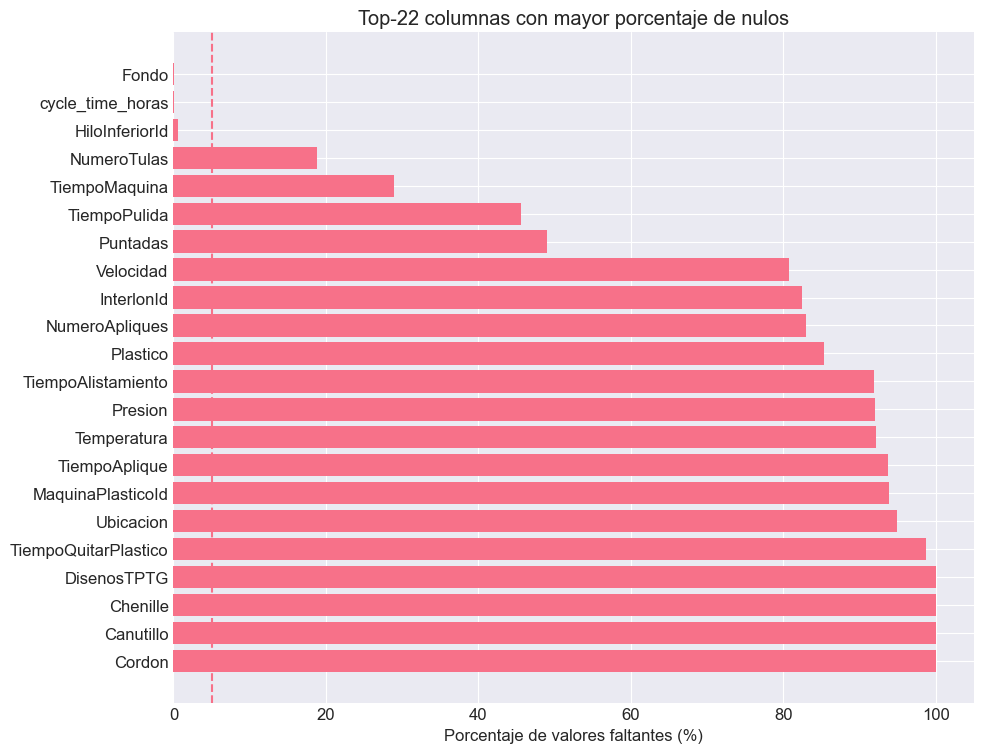

In [ ]:
def plot_missing_bar(missing_table: pd.DataFrame, top_n: int = 25):
    mt = missing_table.copy()
    mt = mt[mt["nulos"] > 0].head(top_n)
    if mt.empty:
        print("No hay columnas con valores faltantes.")
        return
    # Etiquetas envueltas para legibilidad
    labels = ["\n".join(wrap(str(c), width=28)) for c in mt["columna"]]
    y = np.arange(len(mt))
    plt.figure(figsize=(10, max(4, 0.35*len(mt))))
    plt.barh(y, mt["nulos_%"])
    plt.yticks(y, labels)
    plt.xlabel("Porcentaje de valores faltantes (%)")
    plt.title(f"Top-{min(top_n, len(mt))} columnas con mayor porcentaje de nulos")
    # Línea de umbral (ajustable)
    plt.axvline(5, linestyle="--")
    plt.tight_layout()
    plt.show()

plot_missing_bar(missing_df, top_n=25)


#### 5.3. Patrones de ausencia por grupos

Objetivo: identificar si los nulos **se concentran** en ciertos grupos operativos (plantas/líneas, materialidad, máquinas), lo que sugiere causas sistémicas (captura, procesos, turnos).

**Notas:**
- Usaremos el dataset `df_miss` definido en 5.1 (prioridad: `df_lead_clean` → `df_lead` → `df_std` → `df_raw`).
- Ajusta la lista `grupos_candidatos` a las columnas disponibles en tu dataset.


In [ ]:
# Dataset base para missingness ya elegido en 5.1:
assert 'df_miss' in globals(), "df_miss no está definido. Ejecuta 5.1 primero."

# Grupos a evaluar (elige los que existan)
grupos_candidatos = [c for c in ["Ubicacion", "TipoMaterialId", "NombreMaquina", "Operario"] if c in df_miss.columns]

def missing_by_group(df: pd.DataFrame, group_col: str, top_n: int = 20) -> pd.DataFrame:
    """
    Retorna % de nulos por columna dentro de cada categoría de group_col.
    Ordena por promedio de nulos (desc) y muestra top_n columnas con más nulos.
    """
    g = df.groupby(group_col)
    # % de nulos por columna dentro de cada grupo
    miss_pct = g.apply(lambda d: d.isna().mean() * 100)
    # Ordenar columnas por promedio global de nulos
    mean_cols = miss_pct.mean(axis=0).sort_values(ascending=False).head(top_n).index.tolist()
    out = miss_pct[mean_cols].sort_index()
    return out

# Reporte por grupo (impresión controlada)
for g in grupos_candidatos:
    print(f"\n>> % de nulos por columna dentro de cada categoría de: {g}")
    rep = missing_by_group(df_miss, g, top_n=25)
    display(rep)


>> % de nulos por columna dentro de cada categoría de: Ubicacion


C:\Users\jaime\AppData\Local\Temp\ipykernel_18744\859351711.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(group_col)
C:\Users\jaime\AppData\Local\Temp\ipykernel_18744\859351711.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  miss_pct = g.apply(lambda d: d.isna().mean() * 100)


,Cordon,Canutillo,Chenille,DisenosTPTG,TiempoQuitarPlastico,TiempoAplique,NumeroApliques,Presion,Temperatura,MaquinaPlasticoId,TiempoAlistamiento,Plastico,InterlonId,Velocidad,TiempoPulida,Puntadas,NumeroTulas,TiempoMaquina,HiloInferiorId,TipoMaterialId,MaterialIdOrden,NumeroOrden,Operario,ColorFondo,Fondo
Ubicacion,,,,,,,,,,,,,,,,,,,,,,,,,
10 cm abajo del cuello centrado nov 13,100.00,100.00,100.00,100.00,100.00,0.00,100.00,100.00,100.00,100.00,100.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10 cms libres del cuello centrado segun la sra,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
15 cms desde el ruedo centrado,100.00,100.00,100.00,100.00,100.00,100.00,100.00,0.00,0.00,0.00,100.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
18 cm de cuello con hombro hacia abajo,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3 cm desde el cuello hacia abajo y centrado.,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
según estampado previo,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
según instrucciones correo,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
según pieza,100.00,100.00,100.00,100.00,100.00,100.00,0.00,100.00,100.00,100.00,100.00,0.00,100.00,100.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00



>> % de nulos por columna dentro de cada categoría de: TipoMaterialId


C:\Users\jaime\AppData\Local\Temp\ipykernel_18744\859351711.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(group_col)
C:\Users\jaime\AppData\Local\Temp\ipykernel_18744\859351711.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  miss_pct = g.apply(lambda d: d.isna().mean() * 100)


,Cordon,Canutillo,Chenille,DisenosTPTG,TiempoQuitarPlastico,Ubicacion,MaquinaPlasticoId,TiempoAplique,Temperatura,Presion,TiempoAlistamiento,Plastico,NumeroApliques,InterlonId,Velocidad,Puntadas,TiempoPulida,TiempoMaquina,NumeroTulas,HiloInferiorId,cycle_time_horas,Fondo,NumeroOrden,ColorFondo,Operario
TipoMaterialId,,,,,,,,,,,,,,,,,,,,,,,,,
28.00,100.00,100.00,100.00,99.98,98.77,94.86,93.91,93.72,92.10,92.08,91.93,85.38,82.92,82.39,80.78,48.98,45.63,28.86,18.84,0.53,0.08,0.06,0.00,0.00,0.00



>> % de nulos por columna dentro de cada categoría de: NombreMaquina


C:\Users\jaime\AppData\Local\Temp\ipykernel_18744\859351711.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(group_col)
C:\Users\jaime\AppData\Local\Temp\ipykernel_18744\859351711.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  miss_pct = g.apply(lambda d: d.isna().mean() * 100)


,Cordon,Canutillo,Chenille,DisenosTPTG,TiempoQuitarPlastico,Ubicacion,MaquinaPlasticoId,TiempoAplique,Temperatura,Presion,TiempoAlistamiento,InterlonId,Plastico,NumeroApliques,Velocidad,Puntadas,TiempoPulida,TiempoMaquina,NumeroTulas,HiloInferiorId,cycle_time_horas,Fondo,NumeroOrden,ColorFondo,Operario
NombreMaquina,,,,,,,,,,,,,,,,,,,,,,,,,
Bordadora 01,100.00,100.00,100.00,100.00,99.40,96.52,98.79,97.62,96.29,96.45,94.14,89.19,80.34,89.38,89.38,71.49,57.47,36.52,22.72,0.57,0.19,0.00,0.00,0.00,0.00
Bordadora 02,100.00,100.00,100.00,99.98,96.89,90.65,86.89,96.69,81.90,81.80,84.33,79.74,69.08,86.02,80.68,52.54,45.38,32.47,15.35,0.96,0.05,0.23,0.00,0.00,0.00
Bordadora 03,100.00,100.00,100.00,100.00,99.29,96.40,95.29,90.10,94.05,94.08,77.37,67.18,88.97,83.05,61.41,45.36,44.52,22.94,14.85,0.18,0.02,0.00,0.00,0.00,0.00
Bordadora 04,100.00,100.00,100.00,100.00,99.79,95.97,99.74,94.27,99.90,99.90,94.74,78.06,98.18,77.07,71.60,32.38,28.08,21.68,19.31,0.00,0.05,0.00,0.00,0.00,0.00
Bordadora 05,100.00,100.00,100.00,100.00,99.45,95.82,94.93,91.31,94.71,94.71,92.01,83.34,91.22,80.01,82.09,39.77,36.25,21.38,25.44,0.07,0.09,0.00,0.00,0.00,0.00
Bordadora 06,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,99.31,100.00,61.11,100.00,61.11,100.00,100.00,20.14,4.17,2.08,0.00,0.00,0.00,0.00,0.00
Bordadora 07,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,98.96,79.17,100.00,78.12,98.96,98.96,25.00,5.21,0.00,0.00,0.00,0.00,0.00,0.00
Bordadora 08,100.00,100.00,100.00,100.00,99.60,97.11,98.54,91.42,97.08,96.76,90.16,87.55,89.88,89.84,84.66,79.33,61.78,34.62,23.56,1.34,0.00,0.00,0.00,0.00,0.00
Bordadora 09,100.00,100.00,100.00,100.00,99.22,94.81,93.05,90.77,92.46,92.46,94.64,82.57,87.90,85.13,81.71,41.82,37.36,24.17,23.41,0.59,0.07,0.00,0.00,0.00,0.00



>> % de nulos por columna dentro de cada categoría de: Operario


C:\Users\jaime\AppData\Local\Temp\ipykernel_18744\859351711.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(group_col)
C:\Users\jaime\AppData\Local\Temp\ipykernel_18744\859351711.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  miss_pct = g.apply(lambda d: d.isna().mean() * 100)


,Cordon,Canutillo,Chenille,DisenosTPTG,TiempoQuitarPlastico,MaquinaPlasticoId,Temperatura,Presion,Ubicacion,TiempoAlistamiento,TiempoAplique,Plastico,InterlonId,Velocidad,NumeroApliques,Puntadas,TiempoPulida,TiempoMaquina,NumeroTulas,HiloInferiorId,cycle_time_horas,Fondo,NumeroOrden,ColorFondo,Operario
Operario,,,,,,,,,,,,,,,,,,,,,,,,,
Adriana Carolina Arenas Gutierrez,100.00,100.00,100.00,100.00,99.46,96.69,95.31,95.43,96.21,90.07,92.06,87.61,81.89,79.00,81.89,47.77,42.06,25.81,20.94,0.06,0.24,0.00,0.00,0.00,0.00
Alejandro Ospina Ramirez,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,92.19,85.94,84.38,92.19,82.81,79.69,93.75,59.38,18.75,21.88,51.56,1.56,0.00,0.00,0.00,0.00,0.00
Alex Mauricio Arango Ramirez,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,72.73,90.91,100.00,81.82,72.73,36.36,0.00,18.18,54.55,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Alexandra Moncada Rodriguez,100.00,100.00,100.00,100.00,100.00,100.00,99.82,99.63,99.45,99.08,97.43,96.51,97.43,97.25,98.90,93.76,86.79,21.65,23.67,0.00,0.00,0.00,0.00,0.00,0.00
Alexandra Oquendo Arcila,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,83.33,50.00,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yerson David Acosta Casas,100.00,100.00,100.00,100.00,100.00,99.91,99.48,99.48,98.96,96.98,90.25,92.23,94.74,94.13,93.18,78.77,64.45,40.38,25.63,0.00,0.00,0.00,0.00,0.00,0.00
Yhojan Gustavo Jimenez Montes,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,92.31,92.31,76.92,23.08,15.38,0.00,0.00,0.00,0.00,0.00,0.00
Yuliana Andrea Lopez Guzman,100.00,100.00,100.00,100.00,100.00,100.00,98.97,98.97,98.29,100.00,98.63,95.21,97.26,96.58,96.23,88.01,84.59,26.71,17.12,0.00,0.34,0.00,0.00,0.00,0.00


#### 5.4. Coausencia entre variables (correlación de nulos)

Objetivo: detectar **pares/grupos de columnas** que tienden a faltar **simultáneamente**, para diseñar imputaciones coherentes (conjuntas) o decidir exclusión en bloque.

**Metodología:**
- Construimos una matriz binaria `M` con 1 si el valor es nulo y 0 si no lo es.
- Calculamos la correlación de Pearson entre columnas de `M` (equivale a co-ocurrencia de nulos).
- Listamos **los pares con mayor correlación** (> umbral).

In [ ]:

# Seleccionar solo columnas con al menos un nulo
cols_with_na = [c for c in df_miss.columns if df_miss[c].isna().any()]
if len(cols_with_na) >= 2:
    M = df_miss[cols_with_na].isna().astype(int)
    # Correlación de nulos (Pearson)
    corr = M.corr().fillna(0)

    # Extraer top pares más correlacionados (triángulo superior sin diagonal)
    pairs = []
    for i, j in itertools.combinations(range(len(cols_with_na)), 2):
        c_i, c_j = cols_with_na[i], cols_with_na[j]
        val = corr.iloc[i, j]
        pairs.append((c_i, c_j, float(val)))
    pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)

    # Filtrar por un umbral (ajusta si es necesario)
    umbral = 0.5
    top_pairs = [p for p in pairs_sorted if p[2] >= umbral][:50]
    top_pairs_df = pd.DataFrame(top_pairs, columns=["col_1", "col_2", "corr_nulos"])
    print(f"Pares con correlación de nulos >= {umbral} (top {len(top_pairs_df)}):")
    display(top_pairs_df)
else:
    print("No hay suficientes columnas con nulos para analizar coausencia.")


Pares con correlación de nulos >= 0.5 (top 7):


,col_1,col_2,corr_nulos
0,Presion,Temperatura,1.00
1,MaquinaPlasticoId,Presion,0.86
2,MaquinaPlasticoId,Temperatura,0.86
3,InterlonId,Velocidad,0.77
4,Plastico,Presion,0.71
5,Plastico,Temperatura,0.71
6,Plastico,MaquinaPlasticoId,0.62


**Interpretación de la coausencia de nulos**

Los resultados muestran pares de columnas con alta correlación en la ausencia de datos (corr_nulos ≥ 0.5), lo que indica que estas variables tienden a faltar simultáneamente. Los casos más relevantes son:

| Par de columnas | corr_nulos | Interpretación |
|----------------|------------|----------------|
| Presion ↔ Temperatura | 1.00 | La ausencia es idéntica en ambas columnas, lo que sugiere que ambas mediciones dependen del mismo punto del proceso o del mismo instrumento de captura. |
| MaquinaPlasticold ↔ Presion / Temperatura | ~0.86 | Cuando no se registra la máquina asociada a plástico, tampoco se registran los parámetros operativos (presión y temperatura), indicando dependencia estructural: **estas variables solo aplican cuando se trabaja con plástico**. |
| InterlonId ↔ Velocidad | ~0.77 | Los valores de velocidad se omiten principalmente cuando no hay identificación de interlón (posiblemente ciertos tipos de producción no utilizan este insumo). |
| Plastico ↔ Presion / Temperatura / MaquinaPlasticold | ~0.62–0.71 | Reafirma la hipótesis de que presión y temperatura son **variables dependientes del uso de plástico** en el diseño/material del pedido. |

**Conclusión operativa**

Estas variables **no deben imputarse de manera independiente**, sino tratadas como **grupo funcional**:

- `Plastico`, `MaquinaPlasticoId`, `Presion`, `Temperatura` forman un **bloque lógico**:  
  → **Solo aplican para pedidos que usan procesos/planchado/plastisol.**

- `InterlonId` y `Velocidad` forman otro **bloque** condicionado al uso de interlón.

Por lo tanto:

1. Para pedidos donde **Plastico = 0 / No aplica**  
   → `Presion`, `Temperatura` y `MaquinaPlasticoId` deben **permanecer como NaN**  
   y **no imputarse**, ya que el nulo tiene **significado real ("no aplica")**.

2. Para pedidos donde **Plastico = 1** y falten `Presion` / `Temperatura`  
   → Esa ausencia **sí representa un error o falta de captura**, y debe imputarse:
   - con la **mediana por tipo de material**, o
   - con la **mediana por máquina** (`MaquinaPlasticoId`), si está disponible.

3. Para el bloque `InterlonId` y `Velocidad`  
   → La ausencia también sugiere **no aplicación del proceso** más que error de captura.


**Decisión documentada para el pipeline**
- No se imputarán `Presion`, `Temperatura`, `MaquinaPlasticoId`, `Velocidad` cuando el proceso **no aplica** según el diseño del pedido.
- Se imputará únicamente cuando la variable **debería existir**, usando mediana por grupo (material o máquina).
- Los modelos que utilicen estas variables deben incorporar una **bandera binaria**:  
  `usa_plastico = (Plastico == 1)`, `usa_interlon = (InterlonId.notna())`.



#### 5.5. Estrategia de manejo 



### Descripción de Variables

---

### 6. Diccionario y Agrupación de Variables

### 6.1 Agrupación y descripción de variables

| Grupo | Variables | Propósito |
|------|-----------|-----------|
| Identificadores / Llaves | `PedidoId`, `NumeroPedido`, `PedidoDetalleId`, `NumeroOrden`, `MaterialIdOrden`, `MaterialId` | Identificar registros y permitir uniones. No aportan señal para el modelo. |
| Temporal | `FechaIngreso`, `FechaInicio`, `FechaFin`, `año` | Medir tiempos (lead time y cycle time) y análisis estacional. |
| Tamaño / Carga del Pedido | `Cantidad`, `CantidadOrden`, `CantidadProgramada`, `NumeroTulas`, `OrdenesGeneradas` | Representan volumen y planificación del pedido o lote. |
| Producto / Variante | `Talla`, `Fondo`, `ColorFondo`, `MaterialPedido`, `codigoMaterial` | Describen características visuales o comerciales del producto. |
| Materialidad / Receta | `TipoMaterialId`, `InterlonId`, `HiloInferiorId`, `Plastico`, `Canutillo`, `Chenille`, `Cordon` | Definen la composición y materiales que afectan proceso y tiempo. |
| Complejidad de Diseño | `DisenosTPTG`, `NumeroApliques`, `Puntadas`, `PuntoPlantilla` | Miden complejidad del producto y nivel de trabajo requerido. |
| Recursos / Asignación | `NombreMaquina`, `MaquinaPlasticoId`, `Operario`, `Ubicacion` | Indican la máquina, operario o ubicación donde se procesa. |
| Tiempos de Proceso | `TiempoAlistamiento`, `TiempoMaquina`, `TiempoAplique`, `TiempoPulida`, `TiempoQuitarPlastico`, `TiempoenMaquina` | Registrar tiempos operativos reales utilizados en cada fase. |
| Telemetría de Operación | `Velocidad`, `Presion`, `Temperatura` | Indicadores de condiciones de operación de la máquina. |
| Calidad / Resultado | `CantidadBuena`, `CantidadMala`, `CantidadReprocesada` | Medidas de rendimiento y retrabajo del proceso. |



### 6.2  Diccionario de datos (metadata)


#### Identificadores / Llaves

| Campo              | Tipo sugerido | Unidad | Descripción                                                          | Ejemplo            | Nulos |
|--------------------|---------------|--------|----------------------------------------------------------------------|--------------------|-------|
| PedidoId           | int64/string  | —      | Identificador interno del pedido.                                    | 125487             | No    |
| NumeroPedido       | string        | —      | Código/folio visible del pedido.                                     | "PO-2024-000981"   | No    |
| PedidoDetalleId    | int64/string  | —      | Identificador de la línea/detalle del pedido.                        | 881234             | No    |
| NumeroOrden        | string        | —      | Orden de producción asociada.                                        | "OP-77831"         | Sí     |
| MaterialIdOrden    | string        | —      | Id del material específico en la orden.                              | "MAT-ORD-009"      | Sí     |
| MaterialId         | string        | —      | Id de material genérico/catalogado.                                  | "MAT-00123"        | Sí     |

#### Temporal

| Campo         | Tipo sugerido     | Unidad | Descripción                                                         | Ejemplo               | Nulos             |
|---------------|-------------------|--------|---------------------------------------------------------------------|-----------------------|-------------------|
| FechaIngreso  | datetime64[ns]    | —      | Fecha/hora en que el pedido ingresa al sistema.                     | 2024-03-05 08:12:00   | No                |
| FechaInicio   | datetime64[ns]    | —      | Inicio de producción del detalle/pedido.                            | 2024-03-06 14:30:00   | Sí (obs. ~24%)    |
| FechaFin      | datetime64[ns]    | —      | Fin de producción/cierre del detalle/pedido.                        | 2024-03-08 10:05:00   | Sí (obs. ~24%)    |
| año           | int64             | —      | Año calendario de referencia (redundante si se extrae de fechas).   | 2024                  | Sí                |

#### Tamaño / Carga del pedido

| Campo               | Tipo sugerido | Unidad  | Descripción                                              | Ejemplo | Nulos |
|---------------------|---------------|---------|----------------------------------------------------------|---------|-------|
| Cantidad            | int64         | unidades| Unidades solicitadas en el detalle.                      | 250     | No    |
| CantidadOrden       | int64         | unidades| Unidades planificadas en la orden.                       | 250     | Sí     |
| CantidadProgramada  | int64         | unidades| Unidades programadas para producir.                      | 240     | Sí     |
| NumeroTulas         | int64         | bolsas  | Número de tulas/bolsas/paquetes para el detalle.         | 5       | Sí     |
| OrdenesGeneradas    | int64         | conteo  | Número de órdenes emitidas para el pedido.               | 1       | Sí     |

#### Producto / Variante

| Campo          | Tipo sugerido | Unidad | Descripción                                   | Ejemplo         | Nulos |
|----------------|---------------|--------|-----------------------------------------------|-----------------|-------|
| Talla          | string        | —      | Talla/medida del producto.                    | "M"             | Sí     |
| Fondo          | string        | —      | Tipo de fondo/base del diseño.                | "Algodón"       | Sí     |
| ColorFondo     | string        | —      | Color de la base/fondo.                       | "Azul marino"   | Sí     |
| MaterialPedido | string        | —      | Material solicitado (descripción).            | "Poli algodón"  | Sí     |
| codigoMaterial | string        | —      | Código/catálogo del material comercial.       | "COD-PA-450"    | Sí     |

#### Materialidad / Receta

| Campo         | Tipo sugerido | Unidad | Descripción                                              | Ejemplo     | Nulos |
|---------------|---------------|--------|----------------------------------------------------------|-------------|-------|
| TipoMaterialId| string/int    | —      | Tipo/clase de material (categórico).                    | 3           | Sí     |
| InterlonId    | string/int    | —      | Identificador de tipo de entretela/interlón.            | 12          | Sí     |
| HiloInferiorId| string/int    | —      | Identificador del hilo inferior.                        | 7           | Sí     |
| Plastico      | int8/bool     | —      | Indicador de uso de plástico en el diseño.              | 0/1         | Sí     |
| Canutillo     | int8/bool     | —      | Indicador de uso de canutillo.                          | 0/1         | Sí     |
| Chenille      | int8/bool     | —      | Indicador de uso de chenille.                           | 0/1         | Sí     |
| Cordon        | int8/bool     | —      | Indicador de uso de cordón.                             | 0/1         | Sí     |

#### Complejidad de diseño

| Campo          | Tipo sugerido | Unidad    | Descripción                                        | Ejemplo | Nulos |
|----------------|---------------|-----------|----------------------------------------------------|---------|-------|
| DisenosTPTG    | string/int    | —         | Identificador del diseño o familia de diseño.      | "DS-21" | Sí     |
| NumeroApliques | int64         | conteo    | Número de apliques del diseño.                     | 3       | Sí     |
| Puntadas       | int64         | puntadas  | Número estimado/medido de puntadas.                | 185000  | Sí     |
| PuntoPlantilla | string        | —         | Punto/plantilla técnica aplicada.                  | "P-05"  | Sí     |

#### Recursos / Asignación

| Campo            | Tipo sugerido | Unidad | Descripción                                  | Ejemplo       | Nulos |
|------------------|---------------|--------|----------------------------------------------|---------------|-------|
| NombreMaquina    | string        | —      | Máquina/celda asignada.                      | "Bordadora-3" | Sí     |
| MaquinaPlasticoId| string/int    | —      | Id de máquina/plástico relacionado.          | 14            | Sí     |
| Operario         | string        | —      | Operario responsable.                         | "OP-102"      | Sí     |
| Ubicacion        | string        | —      | Planta/área/línea donde se procesa.          | "Planta A"    | Sí     |

#### Tiempos de proceso

| Campo               | Tipo sugerido | Unidad (sugerida) | Descripción                                            | Ejemplo | Nulos |
|---------------------|---------------|-------------------|--------------------------------------------------------|---------|-------|
| TiempoAlistamiento  | float64       | minutos (confirmar)| Tiempo de preparación/alistamiento.                   | 18.0    | Sí     |
| TiempoMaquina       | float64       | minutos (confirmar)| Tiempo efectivo en máquina principal.                 | 95.5    | Sí     |
| TiempoAplique       | float64       | minutos (confirmar)| Tiempo dedicado a apliques.                           | 22.0    | Sí     |
| TiempoPulida        | float64       | minutos (confirmar)| Tiempo de pulida/acabado.                             | 15.0    | Sí     |
| TiempoQuitarPlastico| float64       | minutos (confirmar)| Tiempo de retiro de plástico/protecciones.            | 8.0     | Sí     |
| TiempoenMaquina     | float64       | minutos/horas (confirmar) | Tiempo total en máquina registrado.            | 120.0   | Sí     |

#### Telemetría de operación

| Campo      | Tipo sugerido | Unidad (sugerida) | Descripción                                  | Ejemplo | Nulos |
|------------|---------------|-------------------|----------------------------------------------|---------|-------|
| Velocidad  | float64       | rpm/pps (confirmar)| Velocidad de operación de la máquina.       | 750.0   | Sí     |
| Presion    | float64       | bar/psi (confirmar)| Presión medida durante el proceso.          | 2.1     | Sí     |
| Temperatura| float64       | °C (confirmar)     | Temperatura de operación.                    | 38.5    | Sí     |

#### Calidad / Resultado

| Campo               | Tipo sugerido | Unidad  | Descripción                                    | Ejemplo | Nulos |
|---------------------|---------------|---------|------------------------------------------------|---------|-------|
| CantidadBuena       | int64         | unidades| Unidades conformes/aceptadas.                  | 238     | Sí     |
| CantidadMala        | int64         | unidades| Unidades no conformes/rechazadas.              | 6       | Sí     |
| CantidadReprocesada | int64         | unidades| Unidades que requirieron retrabajo.            | 4       | Sí     |
